### Установка

In [ ]:
!git clone https://github.com/microsoft/ProbTS.git

Cloning into 'ProbTS'...
remote: Enumerating objects: 1403, done.
remote: Counting objects: 100% (455/455), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 1403 (delta 368), reused 311 (delta 311), pack-reused 948 (from 2)
Receiving objects: 100% (1403/1403), 13.64 MiB | 29.21 MiB/s, done.
Resolving deltas: 100% (897/897), done.


In [ ]:
%cd ProbTS

/content/ProbTS


In [ ]:
!ls

checkpoints	    datasets  LICENSE	pyproject.toml	run.sh	     submodules
CODE_OF_CONDUCT.md  docs      notebook	README.md	scripts
config		    exps      probts	run.py		SECURITY.md


In [ ]:
!bash scripts/prepare_datasets.sh "./datasets" --data.data_manager.init_args.dataset traffic_ltsf

gdown is already installed, skipping installation.
Downloading...
From (original): https://drive.google.com/uc?id=1tSc1WA30CL2aMt5hAW7M-d5_0IBz-lJP
From (redirected): https://drive.google.com/uc?id=1tSc1WA30CL2aMt5hAW7M-d5_0IBz-lJP&confirm=t&uuid=549af840-d001-47e9-9e0d-e0646d60c2a9
To: /content/ProbTS/datasets/all_datasets.zip
100% 64.8M/64.8M [00:01<00:00, 34.4MB/s]
Data files are saved to datasets
files are unzipped
datasets prepared done.
100% 1.36M/1.36M [00:00<00:00, 64.6MB/s]
Extracting files...
Path to electrical-power-demand-in-turkey files: ./datasets/kaggle/power Generation and consumption.csv
100% 2.15M/2.15M [00:00<00:00, 112MB/s]
Extracting files...
Path to istanbul-traffic-index files: ./datasets/kaggle/istanbul_traffic.csv


In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install gluonts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 44.1 MB/s eta 0:00:00


In [ ]:
!pip install dotenv

In [ ]:
!pip install reformer-pytorch

In [ ]:
!pip install linear-attention-transformer

In [ ]:
!pip install utilsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from probts.model.forecaster import LinearForecaster, NaiveForecaster, TSDiffCond
from probts.model.forecast_module import ProbTSForecastModule
from probts.data import ProbTSDataModule, DataManager, ProbTSBatchData
from probts.utils import find_best_epoch
from lightning import Trainer
import torch
import matplotlib.pyplot as plt

In [ ]:
import pytorch_lightning as pl
pl.seed_everything(0)

INFO:lightning_fabric.utilities.seed:Seed set to 0


0

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## SSSD, traffic ltsf

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def forecast_and_visualize(batch, model, num_chan=10, num_samples=100, batch_idx=0, context_length=96, prediction_length=96):
    batch_data = ProbTSBatchData(batch, model.device)
    past_target_cdf = model.scaler.transform(batch_data.past_target_cdf)
    future_target_cdf = model.scaler.transform(batch_data.future_target_cdf)
    batch_data.past_target_cdf = past_target_cdf

    with torch.no_grad():
        prediction = model.forecaster.forecast(batch_data, num_samples=num_samples)
    prediction = prediction[batch_idx]

    past_range = range(0, context_length)
    future_range = range(context_length, context_length + prediction_length)
    full_range = range(0, context_length + prediction_length)

    q05 = np.quantile(prediction, 0.05, axis=0)
    q95 = np.quantile(prediction, 0.95, axis=0)
    avg = prediction.mean(axis=0)

    if type(num_chan) is int:
        num_chan = range(num_chan)
    for i in num_chan:
        target = torch.cat([past_target_cdf[batch_idx, -context_length:, i], future_target_cdf[batch_idx, :, i]])
        fig, ax = plt.subplots(figsize=(10, 2))
        ax.plot(full_range, target, color='black', alpha=0.7, label='ground truth')
        ax.plot(future_range, avg[:, i], color='orange', label='average forecasts')
        ax.fill_between(future_range, q05[:, i], q95[:, i], color='orange', alpha=.4, label='interval:0.9')
        plt.legend(loc="center left", bbox_to_anchor=(1.04, 0.5));

In [ ]:
import time

def time_for_forecast(batch, model, n_repeats=10):
    batch_data = ProbTSBatchData(batch, model.device)
    total_time = 0

    for i in range(n_repeats):
        start_time = time.time()
        with torch.no_grad():
            prediction = model.forecaster.forecast(batch_data, num_samples=1)
        total_time += (time.time() - start_time)
    total_time /= n_repeats
    return total_time

In [ ]:
from tqdm import tqdm

def check_metrics_for_samplers(test_dataloader, model, trainer, steps):
    metrics = []
    for num_steps in tqdm(steps):
        model.forecaster.solver_num_steps = num_steps
        res = trainer.test(model=model, dataloaders=test_dataloader)
        metrics += res
    return metrics

In [ ]:
data_manager = DataManager(
    dataset='traffic_ltsf',
    path='datasets',
    context_length=96,
    prediction_length=96,
    scaler='standard',
)

data_module = ProbTSDataModule(
    data_manager=data_manager,
    batch_size=1,
    test_batch_size=1,
    num_workers=8,
)
test_dataloader = data_module.test_dataloader()

Loading Long-term Dataset: traffic_ltsf
val  pred_len: 96 : num_test_windows: 18
test  pred_len: 96 : num_test_windows: 36
Test context length: [96], prediction length: [96]
Validation context length: [96], prediction length: [96]
Training context length: [96], prediction lengths: [96]
Test rolling length: 96
Variable-specific normalization: True


In [ ]:
forecaster = TSDiffCond(
    individual=True,
    use_lags=False,
    use_feat_idx_emb=False,
    use_time_feat=False,
    target_dim=data_manager.target_dim,
    context_length=data_manager.context_length,
    prediction_length=data_manager.prediction_length,
    freq=data_manager.freq,
    lags_list=data_manager.lags_list,
    time_feat_dim=data_manager.time_feat_dim,
    dataset=data_manager.dataset,

      timesteps=500,
      hidden_dim=64,
      step_emb=128,
      num_residual_blocks=3,
      use_scaling=False
)

model = ProbTSForecastModule(
    forecaster=forecaster,
    scaler=data_manager.scaler,
    learning_rate=0.001,
    quantiles_num=20,
)
model = model.load_from_checkpoint('../traffic_epoch=69-step=7000_diffsteps=500.ckpt')

sampling_weight_scheme: none
sampling_weight_scheme: none


In [ ]:
trainer = Trainer(
    accelerator="gpu",
    devices=1,
    strategy="auto",
    max_epochs=50,
    use_distributed_sampler=False,
    limit_train_batches=100,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    default_root_dir='./results',
  check_val_every_n_epoch= 1,
  gradient_clip_val=0.5
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### DDPM

In [ ]:
model.scaler = data_manager.scaler
model.forecaster.solver = 'ddpm'
model.forecaster.solver_num_steps = 500
model.forecaster.solver_schedule = 'linear'
model = model.to('cpu')
model.device

device(type='cpu')

In [ ]:
for batch in test_dataloader:
    break

ddpm_time = time_for_forecast(batch, model, n_repeats=10, model_name='SSSD')

In [ ]:
ddpm_time

{'model_name': 'SSSD',
 'solver': 'ddpm',
 'solver_num_steps': 500,
 'time_per_sample': 21.527450180053712}

In [ ]:
res = trainer.test(model=model, dataloaders=test_dataloader);

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.23427969217300415    │
│     96_test_CRPS-Sum      │    0.11864577978849411    │
│       96_test_MASE        │     1.169246792793274     │
│        96_test_MSE        │   0.0011440777452662587   │
│      96_test_MSE-Sum      │    144.02993774414062     │
│        96_test_ND         │    0.27691203355789185    │
│      96_test_ND-Sum       │    0.14444544911384583    │
│       96_test_NRMSE       │    0.5753190517425537     │
│     96_test_NRMSE-Sum     │    0.23169055581092834    │
│    96_test_weighted_ND    │    0.27691203355789185    │
│  96_test_weighted_ND-Sum  │    0.14444544911384583    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
res

[{'96_test_ND': 0.27691203355789185,
  '96_test_ND-Sum': 0.14444544911384583,
  '96_test_weighted_ND': 0.27691203355789185,
  '96_test_weighted_ND-Sum': 0.14444544911384583,
  '96_test_CRPS': 0.23427969217300415,
  '96_test_CRPS-Sum': 0.11864577978849411,
  '96_test_NRMSE': 0.5753190517425537,
  '96_test_NRMSE-Sum': 0.23169055581092834,
  '96_test_MSE': 0.0011440777452662587,
  '96_test_MSE-Sum': 144.02993774414062,
  '96_test_MASE': 1.169246792793274}]

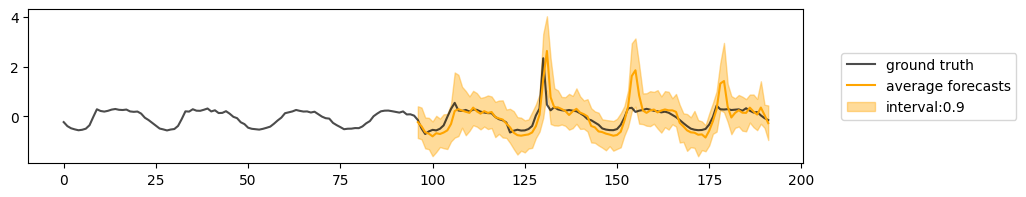

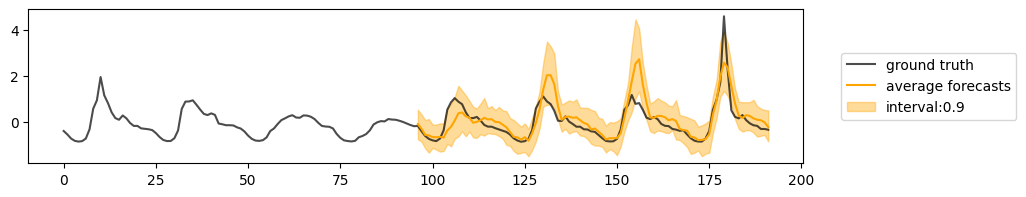

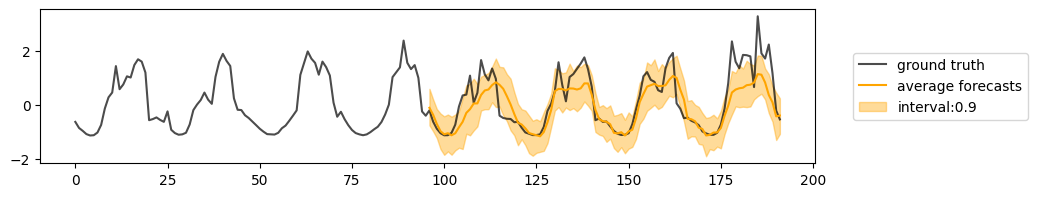

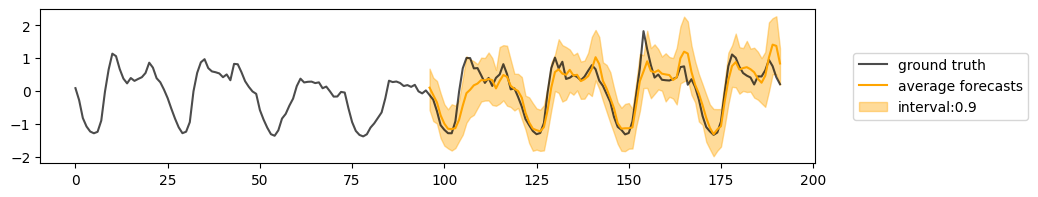

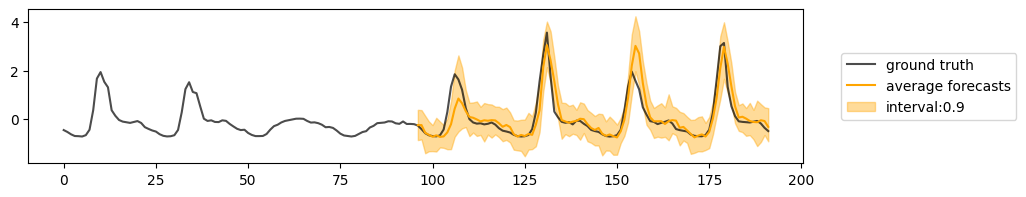

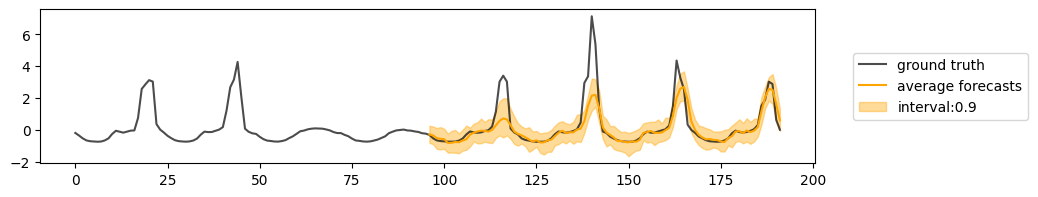

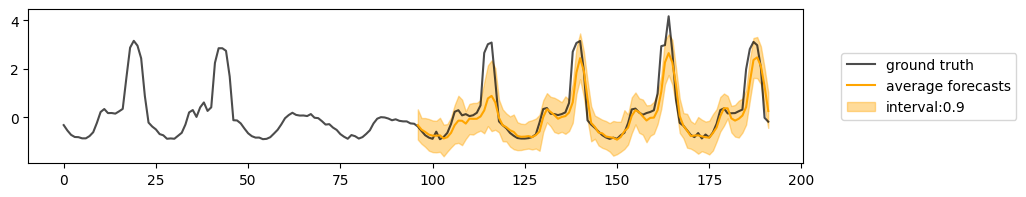

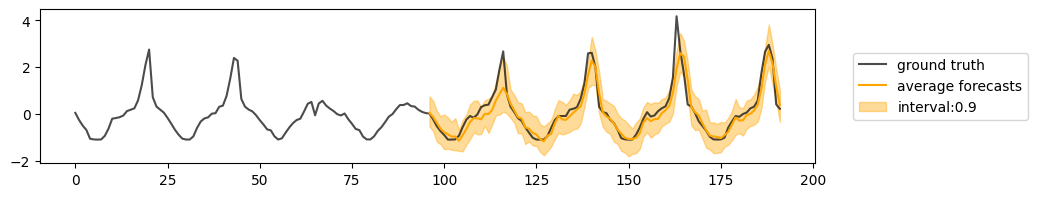

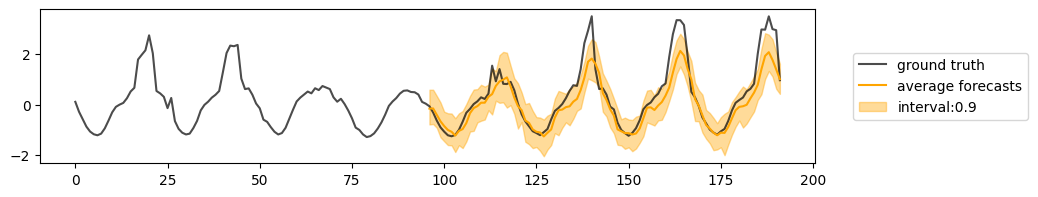

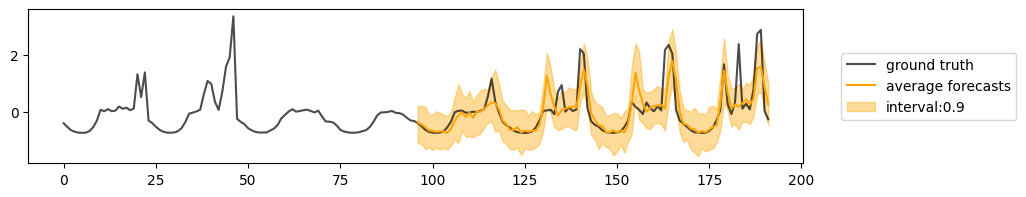

In [ ]:
forecast_and_visualize(batch, model, num_chan=10, num_samples=50, batch_idx=0, context_length=96, prediction_length=96)

### Euler

In [ ]:
model.scaler = data_manager.scaler
model.forecaster.solver = 'euler'
model.forecaster.solver_num_steps = 15
model.forecaster.solver_schedule = 'linear'

for batch in test_dataloader:
    break

In [ ]:
steps = [10, 15, 20, 30, 50, 100]
euler_time = []
for num_steps in tqdm(steps):
    model.forecaster.solver_num_steps = num_steps
    euler_time.append(time_for_forecast(batch, model, n_repeats=10))
euler_time

100%|██████████| 6/6 [02:06<00:00, 21.04s/it]


[0.5579400300979614,
 0.7882563591003418,
 1.0779877662658692,
 1.7068941116333007,
 2.792018508911133,
 5.699031472206116]

In [ ]:
euler_metrics = check_metrics_for_samplers(test_dataloader, model, trainer, steps=[10, 15, 20, 30, 50, 100])

  0%|          | 0/6 [00:00<?, ?it/s]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    1.9927798509597778     │
│     96_test_CRPS-Sum      │    2.2330925464630127     │
│       96_test_MASE        │    10.185650825500488     │
│        96_test_MSE        │    0.02936243638396263    │
│      96_test_MSE-Sum      │       14511.828125        │
│        96_test_ND         │    2.5178117752075195     │
│      96_test_ND-Sum       │     2.584949254989624     │
│       96_test_NRMSE       │     2.971078872680664     │
│     96_test_NRMSE-Sum     │    2.4247968196868896     │
│    96_test_weighted_ND    │    2.5178117752075195     │
│  96_test_weighted_ND-Sum  │     2.584949254989624     │
└───────────────────────────┴───────────────────────────┘

 17%|█▋        | 1/6 [07:21<36:47, 441.46s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2476029098033905     │
│     96_test_CRPS-Sum      │    0.11223816126585007    │
│       96_test_MASE        │    1.1777321100234985     │
│        96_test_MSE        │   0.0010924022644758224   │
│      96_test_MSE-Sum      │     121.3288345336914     │
│        96_test_ND         │    0.2801780104637146     │
│      96_test_ND-Sum       │    0.13887909054756165    │
│       96_test_NRMSE       │    0.5648989677429199     │
│     96_test_NRMSE-Sum     │    0.21653270721435547    │
│    96_test_weighted_ND    │    0.2801780104637146     │
│  96_test_weighted_ND-Sum  │    0.13887909054756165    │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 2/6 [14:38<29:16, 439.06s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.24394668638706207    │
│     96_test_CRPS-Sum      │    0.11777260899543762    │
│       96_test_MASE        │    1.1742860078811646     │
│        96_test_MSE        │   0.0011349805863574147   │
│      96_test_MSE-Sum      │    137.89817810058594     │
│        96_test_ND         │    0.27940693497657776    │
│      96_test_ND-Sum       │    0.14338678121566772    │
│       96_test_NRMSE       │    0.5739789605140686     │
│     96_test_NRMSE-Sum     │    0.22874696552753448    │
│    96_test_weighted_ND    │    0.27940693497657776    │
│  96_test_weighted_ND-Sum  │    0.14338678121566772    │
└───────────────────────────┴───────────────────────────┘

 50%|█████     | 3/6 [21:58<21:57, 439.30s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.24049095809459686    │
│     96_test_CRPS-Sum      │    0.11971104145050049    │
│       96_test_MASE        │    1.1722676753997803     │
│        96_test_MSE        │   0.001149656600318849    │
│      96_test_MSE-Sum      │      144.6435546875       │
│        96_test_ND         │    0.2785507142543793     │
│      96_test_ND-Sum       │    0.14526408910751343    │
│       96_test_NRMSE       │    0.5769211053848267     │
│     96_test_NRMSE-Sum     │    0.23312585055828094    │
│    96_test_weighted_ND    │    0.2785507142543793     │
│  96_test_weighted_ND-Sum  │    0.14526408910751343    │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 4/6 [29:28<14:46, 443.42s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.23876041173934937    │
│     96_test_CRPS-Sum      │    0.12136144936084747    │
│       96_test_MASE        │    1.1744812726974487     │
│        96_test_MSE        │   0.001159757375717163    │
│      96_test_MSE-Sum      │    149.10482788085938     │
│        96_test_ND         │    0.2789042890071869     │
│      96_test_ND-Sum       │    0.1475207358598709     │
│       96_test_NRMSE       │    0.5792522430419922     │
│     96_test_NRMSE-Sum     │    0.23639367520809174    │
│    96_test_weighted_ND    │    0.2789042890071869     │
│  96_test_weighted_ND-Sum  │    0.1475207358598709     │
└───────────────────────────┴───────────────────────────┘

 83%|████████▎ | 5/6 [37:13<07:31, 451.24s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.23760955035686493    │
│     96_test_CRPS-Sum      │    0.12190273404121399    │
│       96_test_MASE        │    1.1757808923721313     │
│        96_test_MSE        │    0.0011635358678177     │
│      96_test_MSE-Sum      │    150.99253845214844     │
│        96_test_ND         │    0.27889981865882874    │
│      96_test_ND-Sum       │    0.14833176136016846    │
│       96_test_NRMSE       │    0.5797113180160522     │
│     96_test_NRMSE-Sum     │    0.23688483238220215    │
│    96_test_weighted_ND    │    0.27889981865882874    │
│  96_test_weighted_ND-Sum  │    0.14833176136016846    │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 6/6 [45:37<00:00, 456.23s/it]


In [ ]:
import pickle
with open("euler_metrics_sssd.pkl", "wb") as fp:
   pickle.dump(euler_metrics, fp)

10


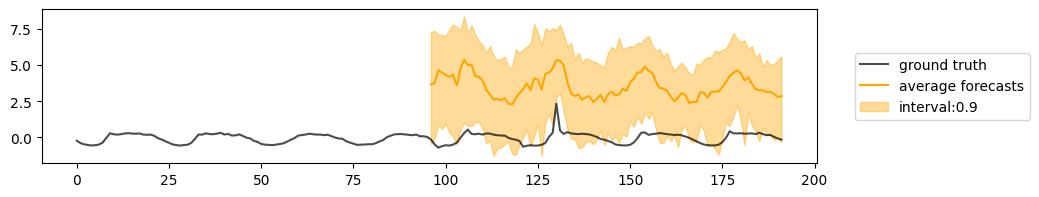

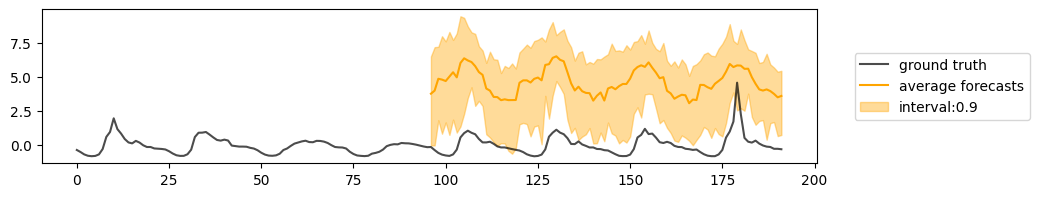

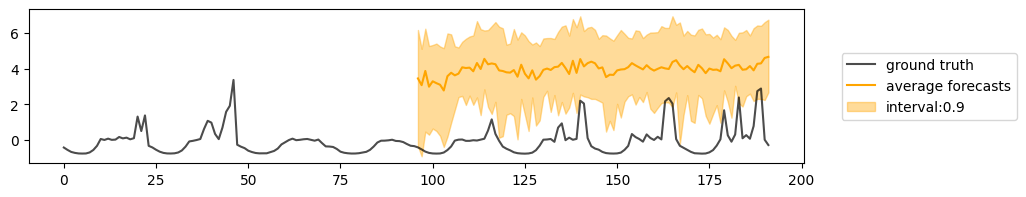

15


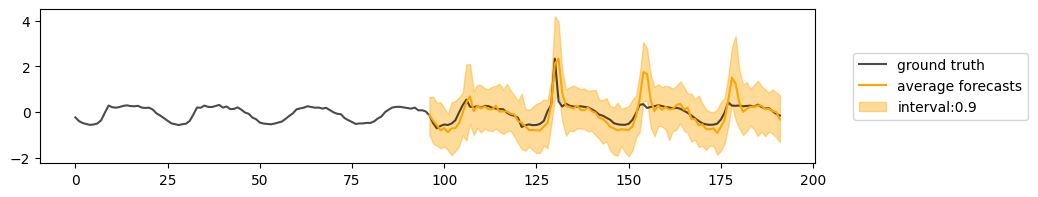

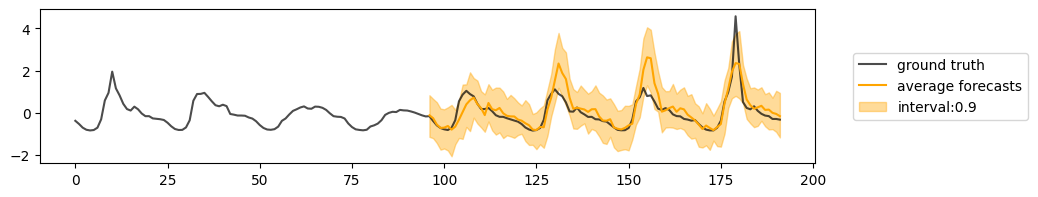

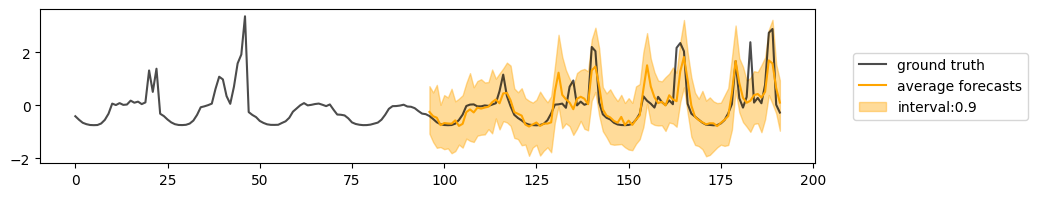

20


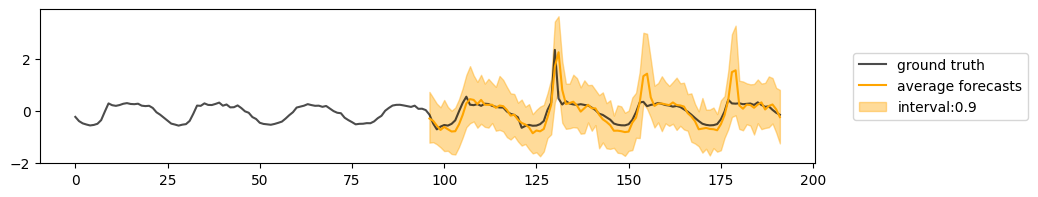

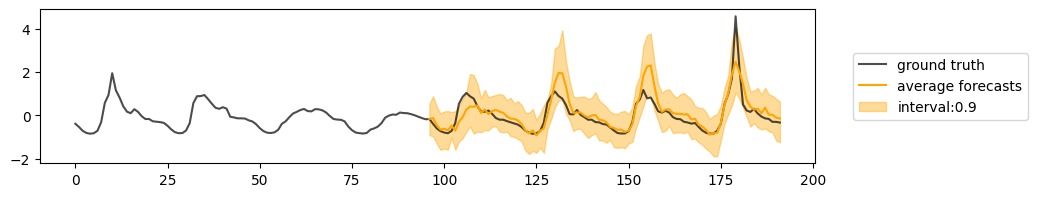

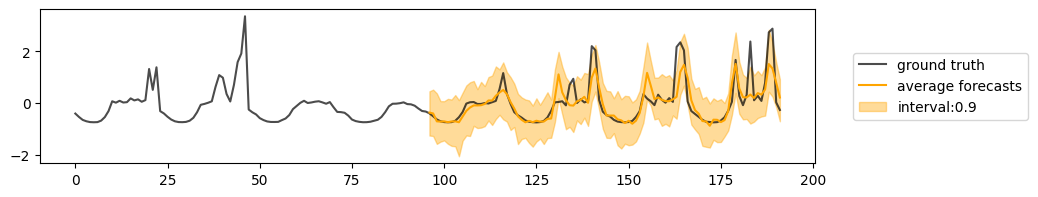

30


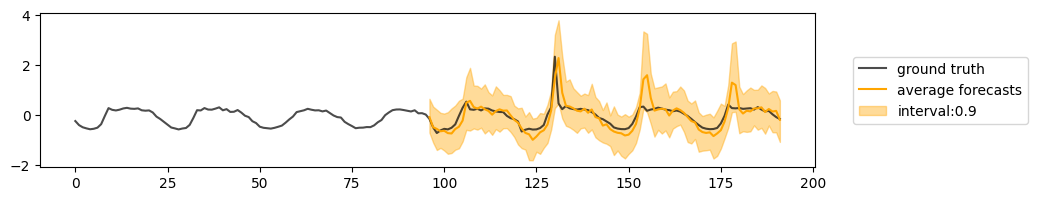

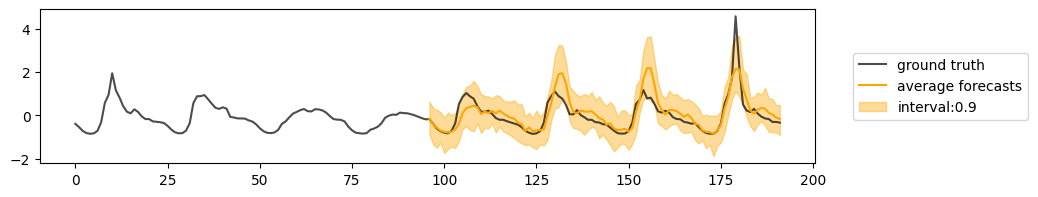

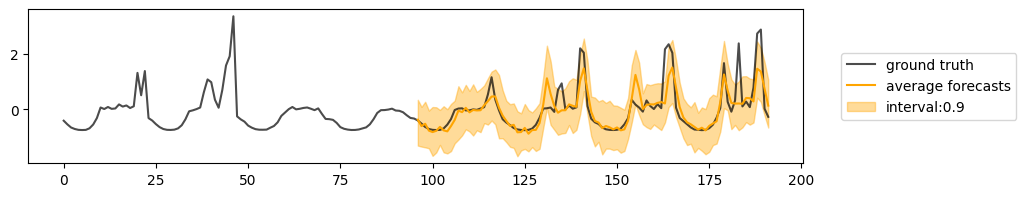

50


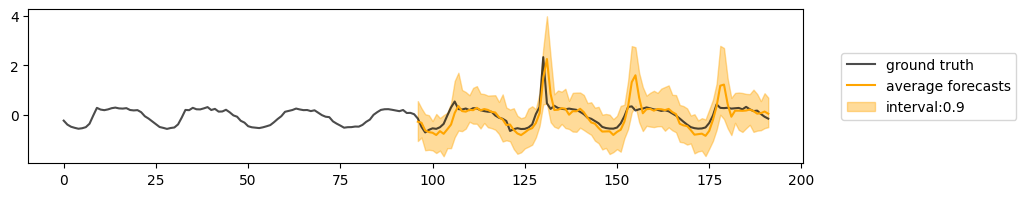

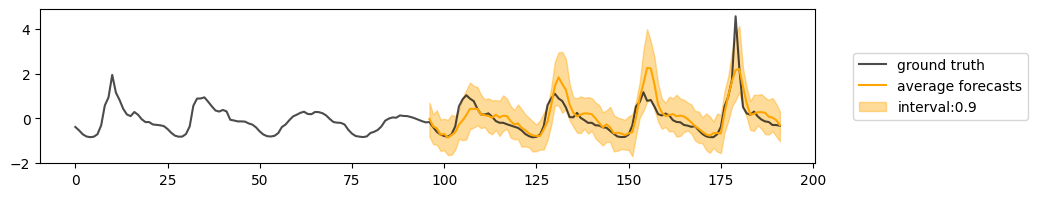

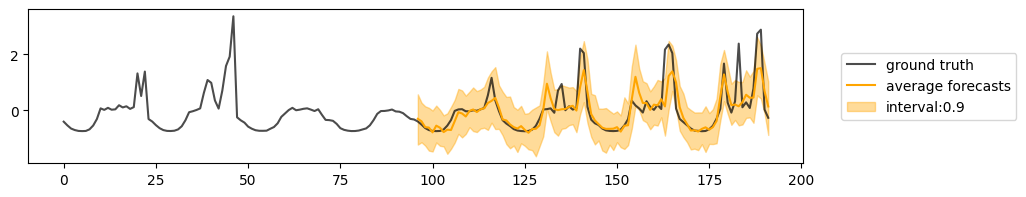

100


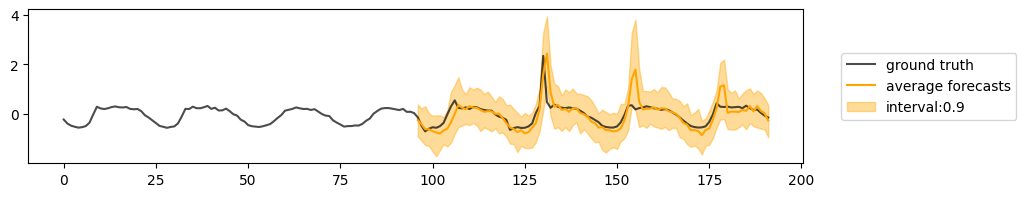

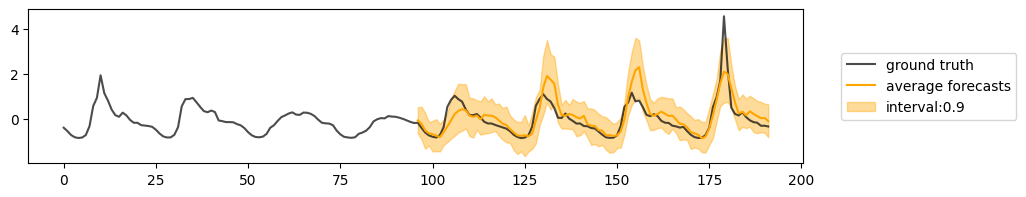

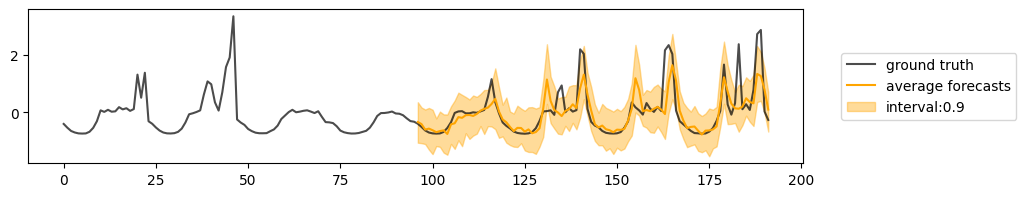

In [ ]:
for num_steps in steps:
    print(num_steps)
    model.forecaster.solver_num_steps = num_steps
    forecast_and_visualize(batch, model, num_chan=[0, 1, 9], num_samples=50, batch_idx=0, context_length=96, prediction_length=96)
    plt.show()

### Heun

In [ ]:
model.forecaster.solver = 'heun'
model.scaler = data_manager.scaler
model.forecaster.solver_num_steps = 15
model.forecaster.solver_schedule = 'linear'
steps = [10, 15, 20, 30, 50, 100]

for batch in test_dataloader:
    break

In [ ]:
heun_time = []
for num_steps in tqdm(steps):
    model.forecaster.solver_num_steps = num_steps // 2
    heun_time.append(time_for_forecast(batch, model, n_repeats=10))
heun_time

100%|██████████| 6/6 [02:00<00:00, 20.14s/it]


[0.4971158027648926,
 0.6482475757598877,
 1.0371903657913208,
 1.625330352783203,
 2.7402133464813234,
 5.537216854095459]

In [ ]:
heun_metrics = check_metrics_for_samplers(test_dataloader, model, trainer, steps=[step // 2 for step in steps])

  0%|          | 0/6 [00:00<?, ?it/s]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │     8.675202369689941     │
│     96_test_CRPS-Sum      │    0.7990835905075073     │
│       96_test_MASE        │    15.946367263793945     │
│        96_test_MSE        │   0.059775374829769135    │
│      96_test_MSE-Sum      │     3606.939697265625     │
│        96_test_ND         │     3.716993570327759     │
│      96_test_ND-Sum       │    1.0766401290893555     │
│       96_test_NRMSE       │     4.226179599761963     │
│     96_test_NRMSE-Sum     │    1.2103376388549805     │
│    96_test_weighted_ND    │     3.716993570327759     │
│  96_test_weighted_ND-Sum  │    1.0766401290893555     │
└───────────────────────────┴───────────────────────────┘

 17%|█▋        | 1/6 [07:19<36:36, 439.27s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    1.7905036211013794     │
│     96_test_CRPS-Sum      │    2.4336256980895996     │
│       96_test_MASE        │    10.364428520202637     │
│        96_test_MSE        │   0.033745791763067245    │
│      96_test_MSE-Sum      │      16027.947265625      │
│        96_test_ND         │     2.556002140045166     │
│      96_test_ND-Sum       │    2.4808642864227295     │
│       96_test_NRMSE       │    3.1832594871520996     │
│     96_test_NRMSE-Sum     │    2.5476338863372803     │
│    96_test_weighted_ND    │     2.556002140045166     │
│  96_test_weighted_ND-Sum  │    2.4808642864227295     │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 2/6 [14:35<29:09, 437.29s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2619321942329407     │
│     96_test_CRPS-Sum      │    0.1463351994752884     │
│       96_test_MASE        │    1.3490170240402222     │
│        96_test_MSE        │   0.0012510332744568586   │
│      96_test_MSE-Sum      │     187.6485137939453     │
│        96_test_ND         │    0.3261505365371704     │
│      96_test_ND-Sum       │    0.18132397532463074    │
│       96_test_NRMSE       │    0.6102455258369446     │
│     96_test_NRMSE-Sum     │    0.2707791328430176     │
│    96_test_weighted_ND    │    0.3261505365371704     │
│  96_test_weighted_ND-Sum  │    0.18132397532463074    │
└───────────────────────────┴───────────────────────────┘

 50%|█████     | 3/6 [21:57<21:59, 439.71s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │     0.262309730052948     │
│     96_test_CRPS-Sum      │    0.17099104821681976    │
│       96_test_MASE        │    1.2990105152130127     │
│        96_test_MSE        │   0.0014635841362178326   │
│      96_test_MSE-Sum      │     253.7364959716797     │
│        96_test_ND         │    0.3099372684955597     │
│      96_test_ND-Sum       │    0.1991494596004486     │
│       96_test_NRMSE       │    0.6423158645629883     │
│     96_test_NRMSE-Sum     │    0.30168646574020386    │
│    96_test_weighted_ND    │    0.3099372684955597     │
│  96_test_weighted_ND-Sum  │    0.1991494596004486     │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 4/6 [29:27<14:46, 443.48s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.24982835352420807    │
│     96_test_CRPS-Sum      │    0.14740398526191711    │
│       96_test_MASE        │    1.2321768999099731     │
│        96_test_MSE        │   0.001319969305768609    │
│      96_test_MSE-Sum      │    207.65225219726562     │
│        96_test_ND         │    0.2938889265060425     │
│      96_test_ND-Sum       │    0.17539887130260468    │
│       96_test_NRMSE       │    0.6138036847114563     │
│     96_test_NRMSE-Sum     │    0.2751413881778717     │
│    96_test_weighted_ND    │    0.2938889265060425     │
│  96_test_weighted_ND-Sum  │    0.17539887130260468    │
└───────────────────────────┴───────────────────────────┘

 83%|████████▎ | 5/6 [37:13<07:31, 451.67s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.24025554955005646    │
│     96_test_CRPS-Sum      │    0.12987475097179413    │
│       96_test_MASE        │     1.188880205154419     │
│        96_test_MSE        │   0.0012076719431206584   │
│      96_test_MSE-Sum      │    168.57879638671875     │
│        96_test_ND         │    0.2827266752719879     │
│      96_test_ND-Sum       │    0.1569311022758484     │
│       96_test_NRMSE       │    0.5895707607269287     │
│     96_test_NRMSE-Sum     │    0.2495301067829132     │
│    96_test_weighted_ND    │    0.2827266752719879     │
│  96_test_weighted_ND-Sum  │    0.1569311022758484     │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 6/6 [45:39<00:00, 456.60s/it]


In [ ]:
import pickle
with open("heun_metrics_sssd.pkl", "wb") as fp:
   pickle.dump(heun_metrics, fp)

10


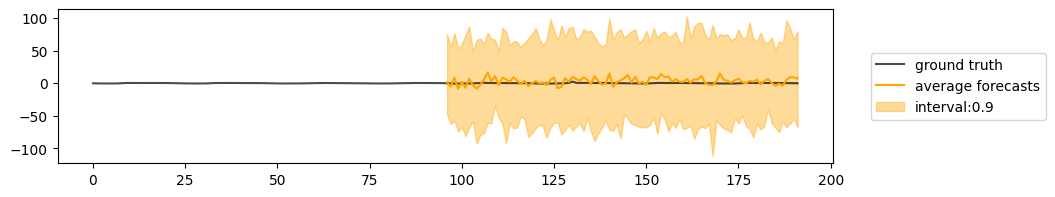

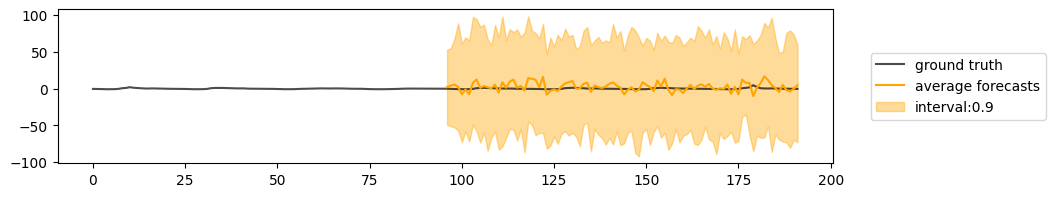

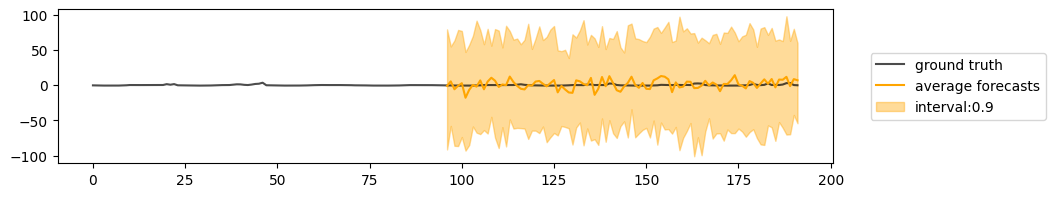

15


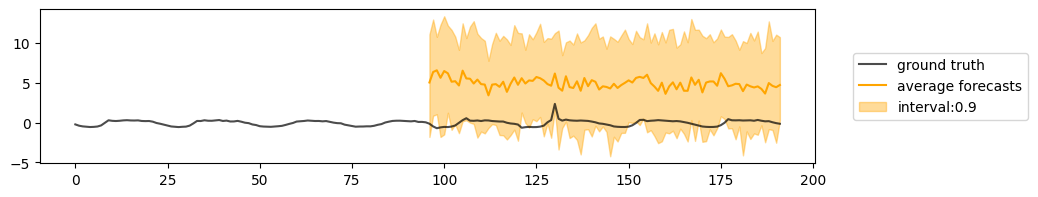

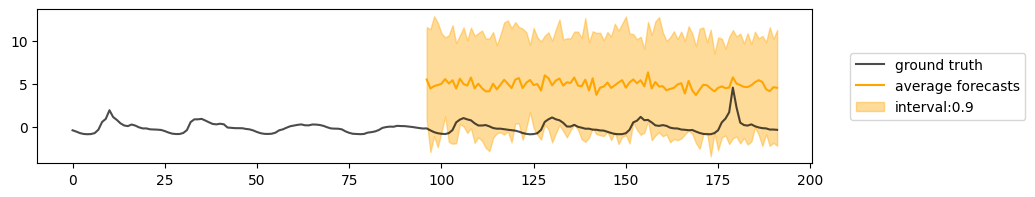

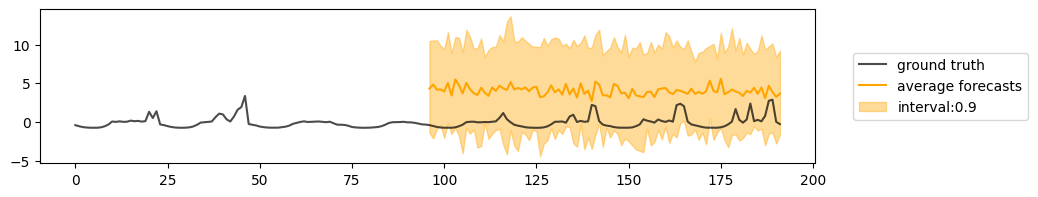

20


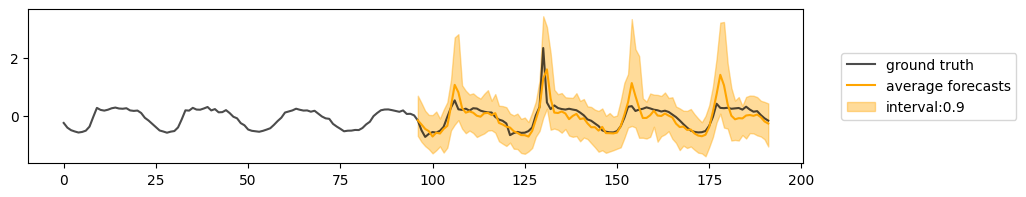

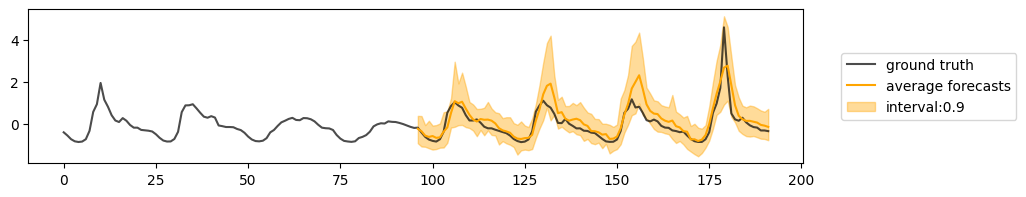

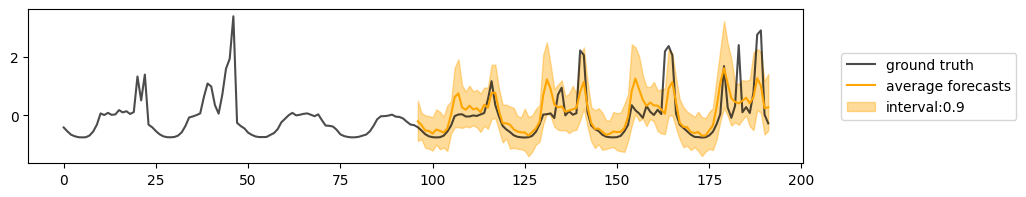

30


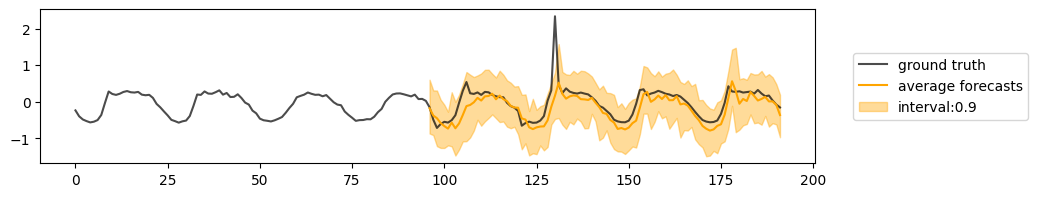

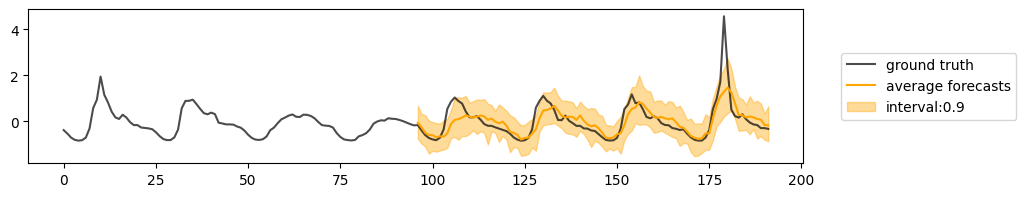

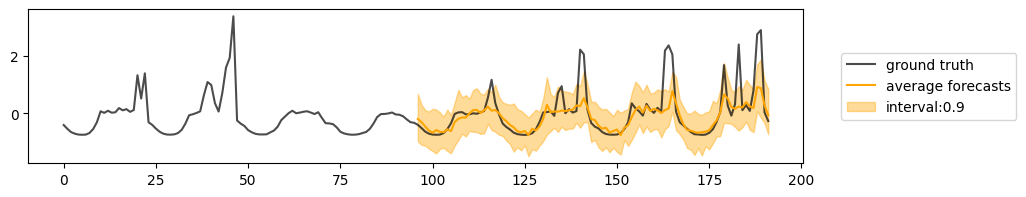

50


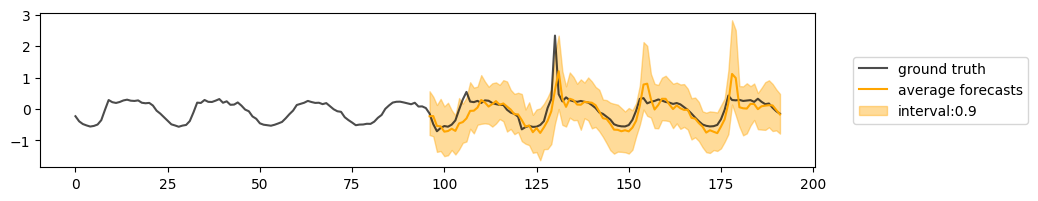

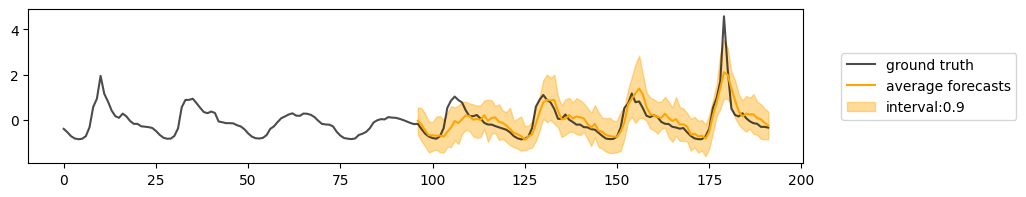

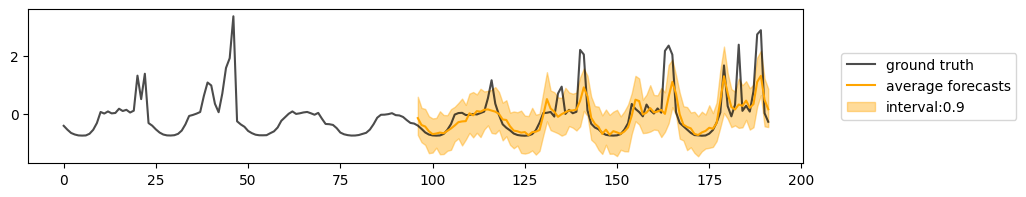

100


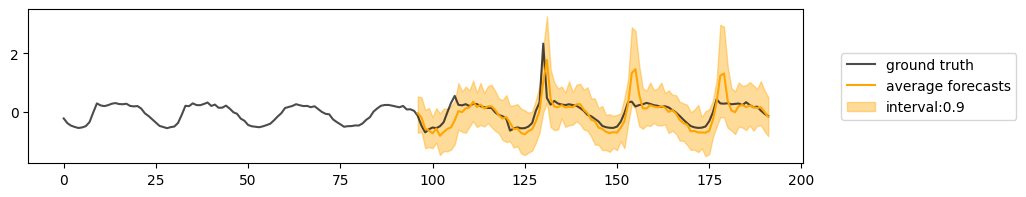

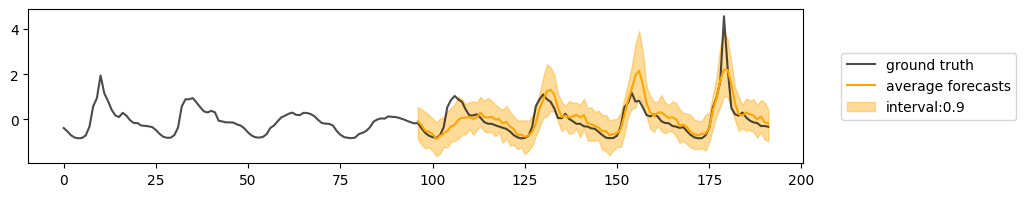

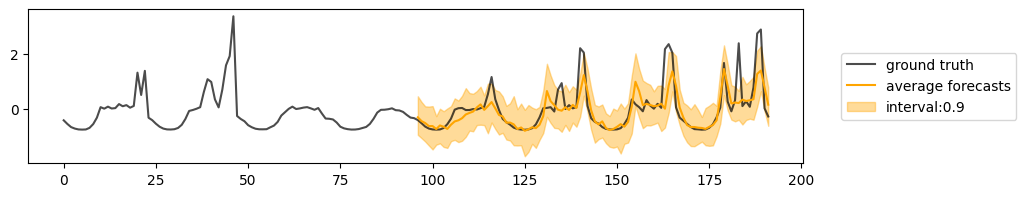

In [ ]:
for num_steps in steps:
    print(num_steps)
    model.forecaster.solver_num_steps = num_steps // 2
    forecast_and_visualize(batch, model, num_chan=[0, 1, 9], num_samples=50, batch_idx=0, context_length=96, prediction_length=96)
    plt.show()

### DDIM, quad

In [ ]:
model.forecaster.solver = 'ddim'
model.forecaster.solver_schedule = 'quad'

for batch in test_dataloader:
    break

In [ ]:
ddim_time = []
for num_steps in tqdm(steps):
    model.forecaster.solver_num_steps = num_steps
    ddim_time.append(time_for_forecast(batch, model, n_repeats=10))
ddim_time

100%|██████████| 6/6 [02:02<00:00, 20.41s/it]


[0.48334474563598634,
 0.8063222169876099,
 1.0762452840805055,
 1.6047282218933105,
 2.7213833570480346,
 5.555305361747742]

In [ ]:
ddim_quad_metrics = check_metrics_for_samplers(test_dataloader, model, trainer, steps=steps)

  0%|          | 0/6 [00:00<?, ?it/s]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2602124512195587     │
│     96_test_CRPS-Sum      │     0.164949432015419     │
│       96_test_MASE        │    1.3534984588623047     │
│        96_test_MSE        │   0.0012973641278222203   │
│      96_test_MSE-Sum      │       193.251953125       │
│        96_test_ND         │    0.3202618360519409     │
│      96_test_ND-Sum       │    0.20136843621730804    │
│       96_test_NRMSE       │    0.6123821139335632     │
│     96_test_NRMSE-Sum     │    0.27266180515289307    │
│    96_test_weighted_ND    │    0.3202618360519409     │
│  96_test_weighted_ND-Sum  │    0.20136843621730804    │
└───────────────────────────┴───────────────────────────┘

 17%|█▋        | 1/6 [07:11<35:59, 431.86s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25895702838897705    │
│     96_test_CRPS-Sum      │    0.16694973409175873    │
│       96_test_MASE        │    1.3059555292129517     │
│        96_test_MSE        │   0.0013452641433104873   │
│      96_test_MSE-Sum      │    213.92860412597656     │
│        96_test_ND         │    0.31105074286460876    │
│      96_test_ND-Sum       │    0.2004687339067459     │
│       96_test_NRMSE       │    0.6211576461791992     │
│     96_test_NRMSE-Sum     │    0.28361770510673523    │
│    96_test_weighted_ND    │    0.31105074286460876    │
│  96_test_weighted_ND-Sum  │    0.2004687339067459     │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 2/6 [14:28<28:58, 434.70s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2575092613697052     │
│     96_test_CRPS-Sum      │    0.16318786144256592    │
│       96_test_MASE        │     1.29022216796875      │
│        96_test_MSE        │   0.0013331789523363113   │
│      96_test_MSE-Sum      │    210.90435791015625     │
│        96_test_ND         │    0.3075311779975891     │
│      96_test_ND-Sum       │    0.19654586911201477    │
│       96_test_NRMSE       │    0.6184205412864685     │
│     96_test_NRMSE-Sum     │    0.2813332676887512     │
│    96_test_weighted_ND    │    0.3075311779975891     │
│  96_test_weighted_ND-Sum  │    0.19654586911201477    │
└───────────────────────────┴───────────────────────────┘

 50%|█████     | 3/6 [21:48<21:51, 437.13s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2549976706504822     │
│     96_test_CRPS-Sum      │    0.15493077039718628    │
│       96_test_MASE        │    1.2678695917129517     │
│        96_test_MSE        │   0.0013088556006550789   │
│      96_test_MSE-Sum      │    202.70416259765625     │
│        96_test_ND         │    0.3022178113460541     │
│      96_test_ND-Sum       │     0.188656747341156     │
│       96_test_NRMSE       │    0.6131060123443604     │
│     96_test_NRMSE-Sum     │    0.27570417523384094    │
│    96_test_weighted_ND    │    0.3022178113460541     │
│  96_test_weighted_ND-Sum  │     0.188656747341156     │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 4/6 [29:14<14:41, 440.72s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25306475162506104    │
│     96_test_CRPS-Sum      │    0.1489814817905426     │
│       96_test_MASE        │    1.2543940544128418     │
│        96_test_MSE        │   0.0012848417973145843   │
│      96_test_MSE-Sum      │    194.11480712890625     │
│        96_test_ND         │    0.2989196479320526     │
│      96_test_ND-Sum       │    0.18338258564472198    │
│       96_test_NRMSE       │    0.6075644493103027     │
│     96_test_NRMSE-Sum     │    0.2694118618965149     │
│    96_test_weighted_ND    │    0.2989196479320526     │
│  96_test_weighted_ND-Sum  │    0.18338258564472198    │
└───────────────────────────┴───────────────────────────┘

 83%|████████▎ | 5/6 [36:54<07:27, 447.44s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2516605854034424     │
│     96_test_CRPS-Sum      │      0.144775390625       │
│       96_test_MASE        │    1.2449066638946533     │
│        96_test_MSE        │   0.0012671758886426687   │
│      96_test_MSE-Sum      │    188.39096069335938     │
│        96_test_ND         │    0.29645365476608276    │
│      96_test_ND-Sum       │    0.17953404784202576    │
│       96_test_NRMSE       │    0.6034756302833557     │
│     96_test_NRMSE-Sum     │    0.2651852071285248     │
│    96_test_weighted_ND    │    0.29645365476608276    │
│  96_test_weighted_ND-Sum  │    0.17953404784202576    │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 6/6 [45:10<00:00, 451.73s/it]


In [ ]:
with open("ddim_quad_metrics_sssd.pkl", "wb") as fp:
   pickle.dump(ddim_quad_metrics, fp)

10


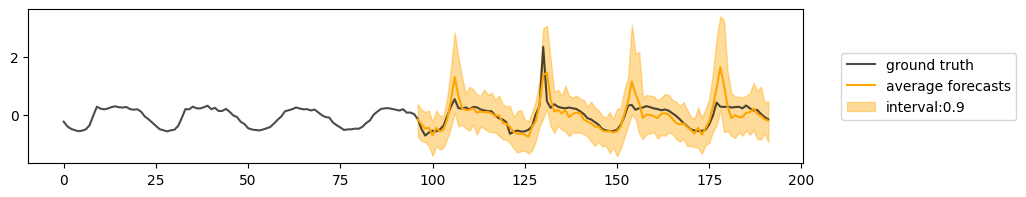

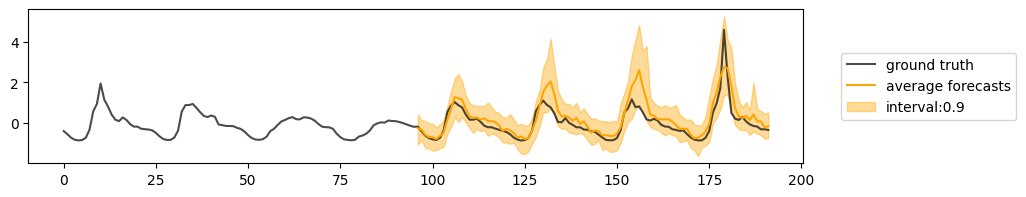

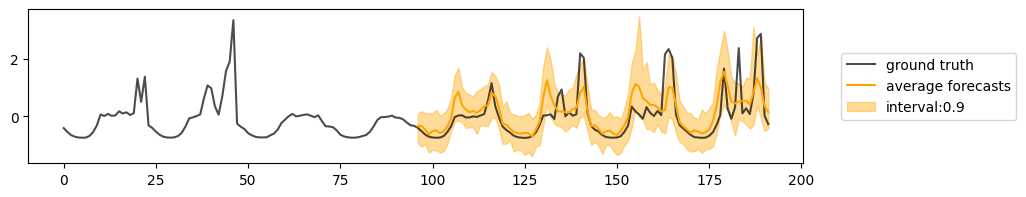

15


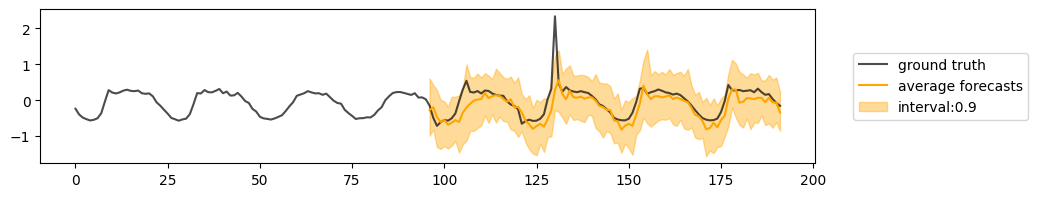

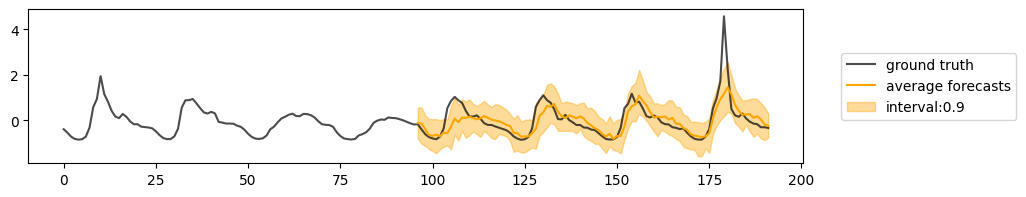

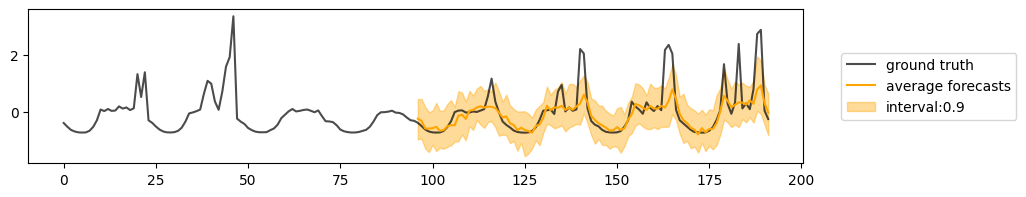

20


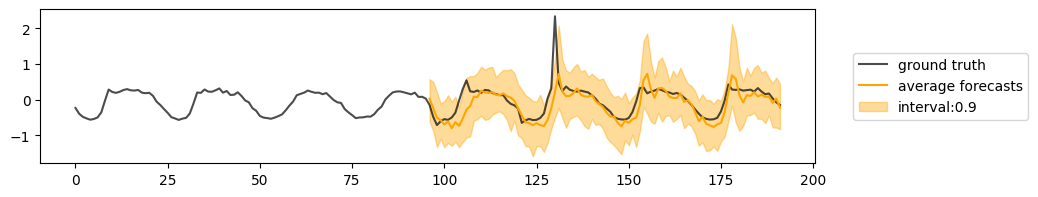

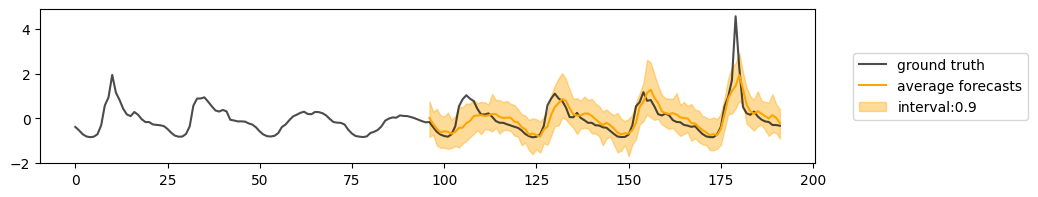

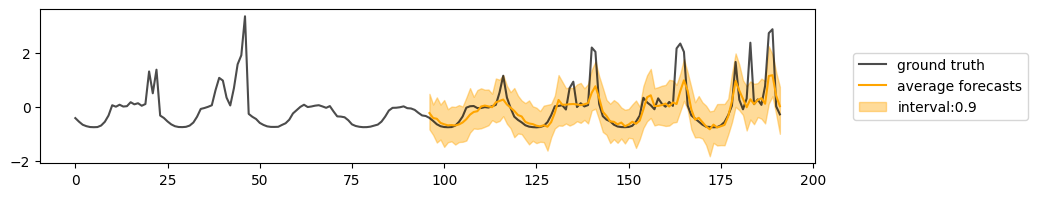

30


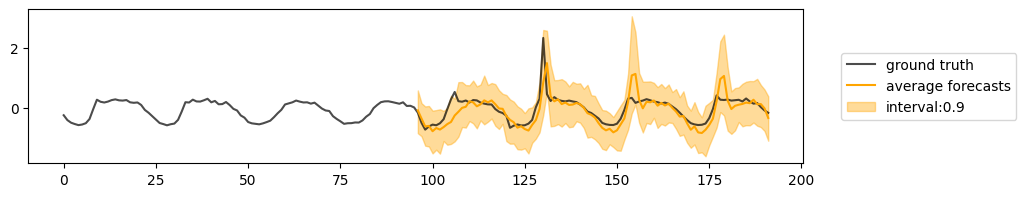

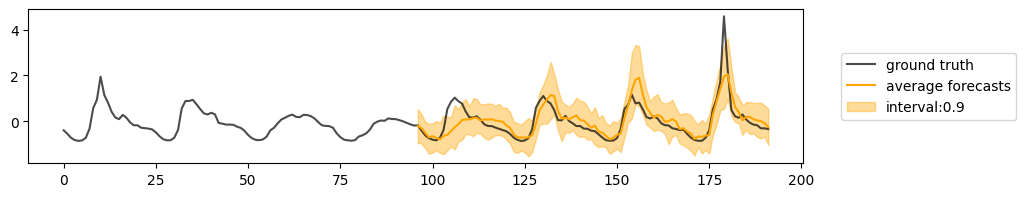

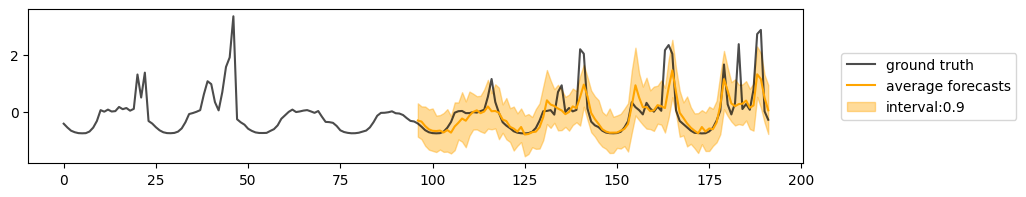

50


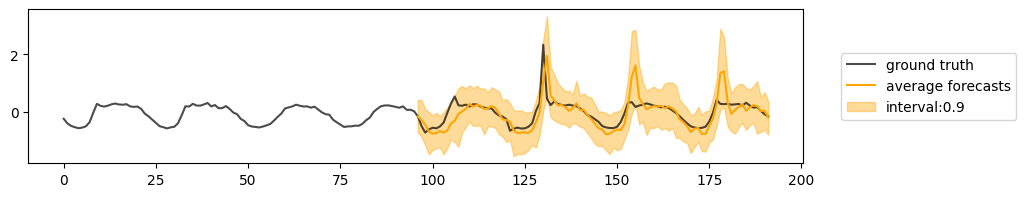

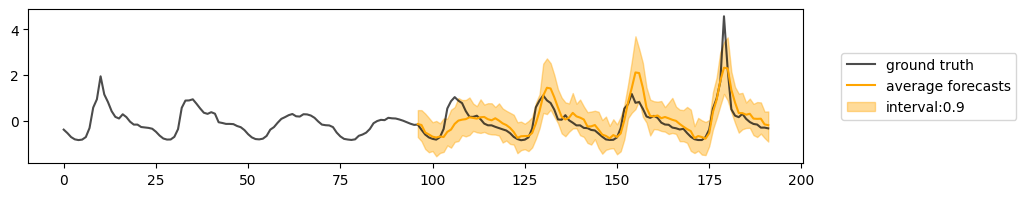

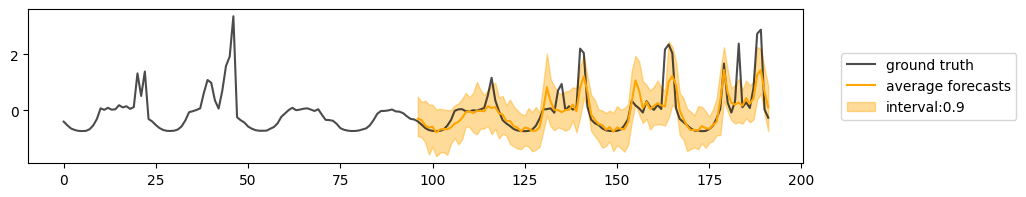

100


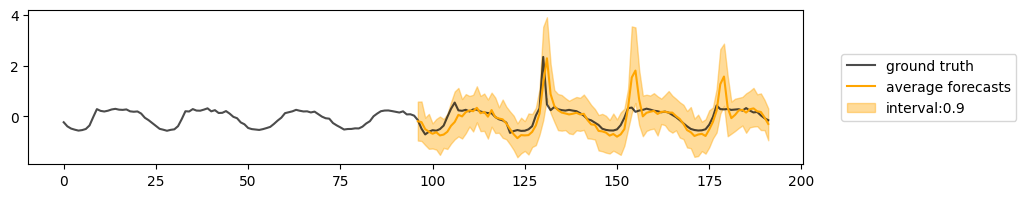

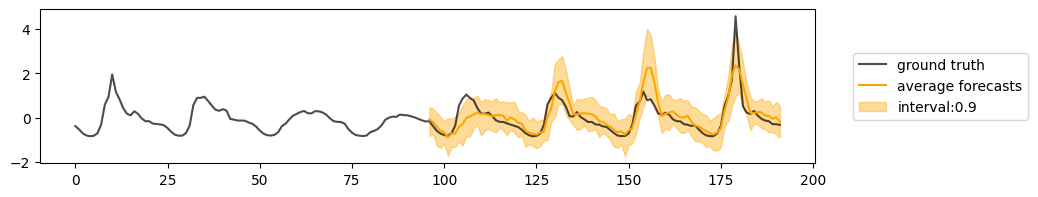

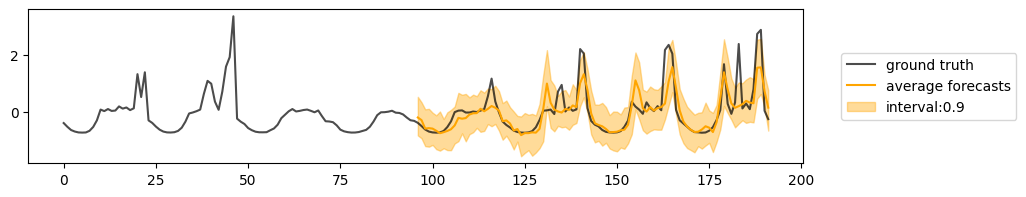

In [ ]:
for num_steps in steps:
    print(num_steps)
    model.forecaster.solver_num_steps = num_steps
    forecast_and_visualize(batch, model, num_chan=[0, 1, 9], num_samples=50, batch_idx=0, context_length=96, prediction_length=96)
    plt.show()

### DDIM, linear

10


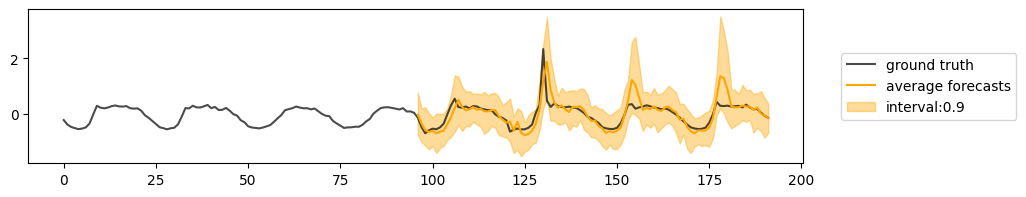

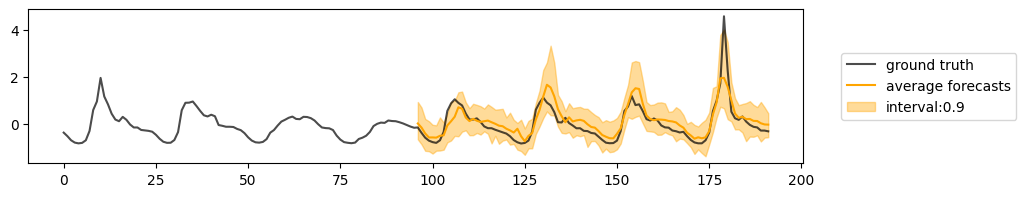

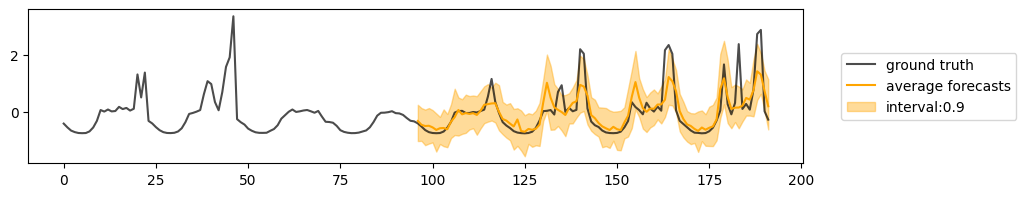

15


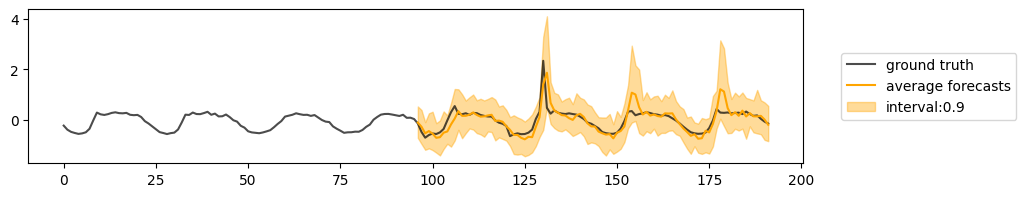

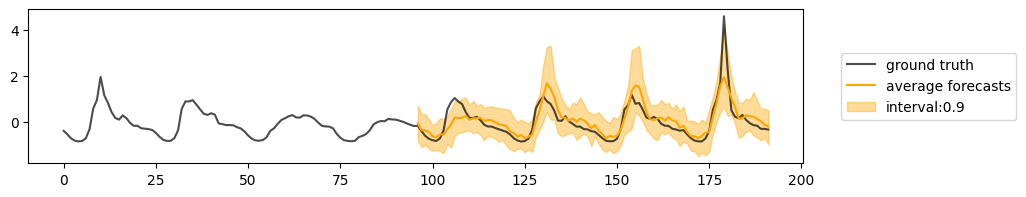

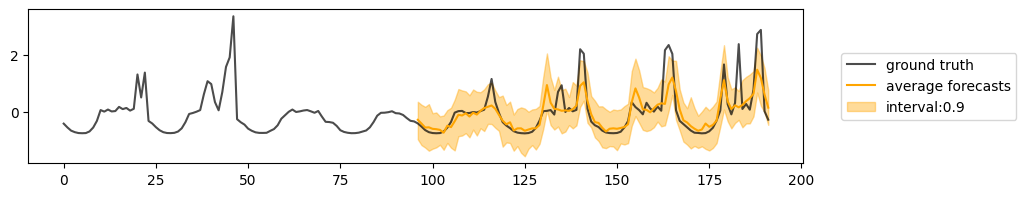

20


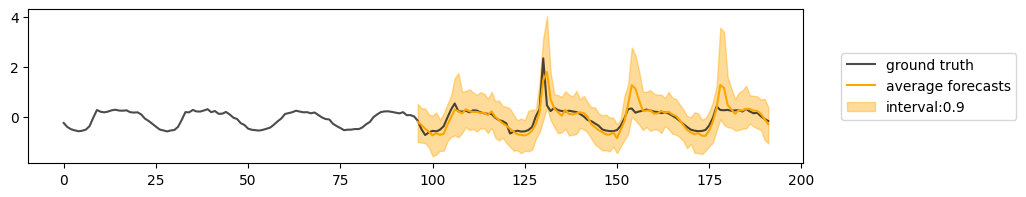

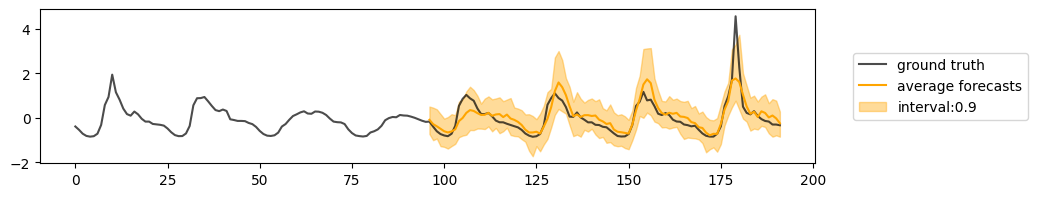

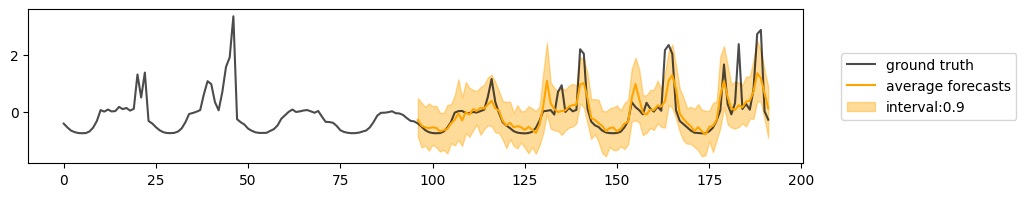

30


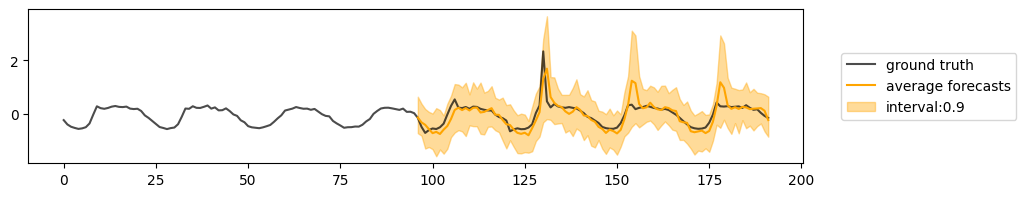

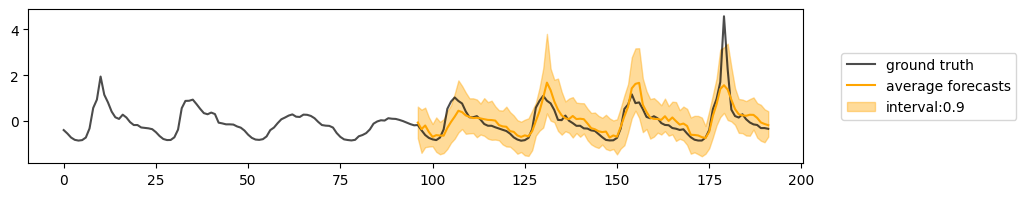

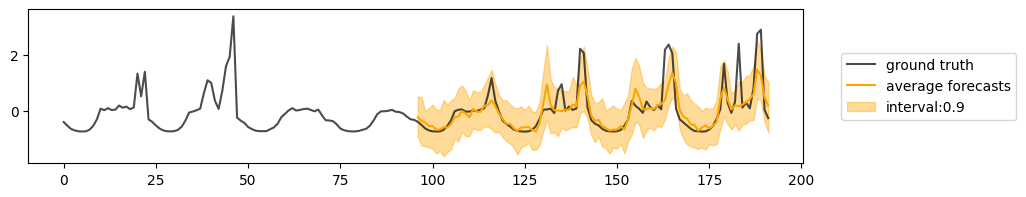

50


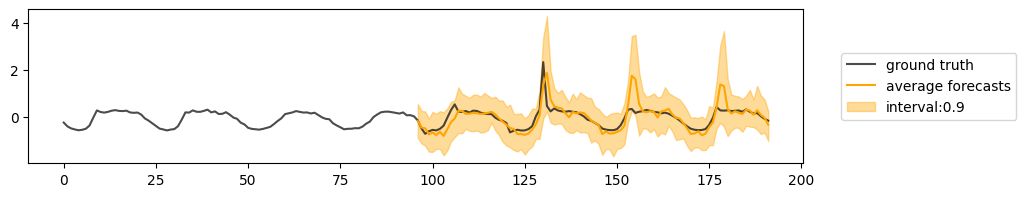

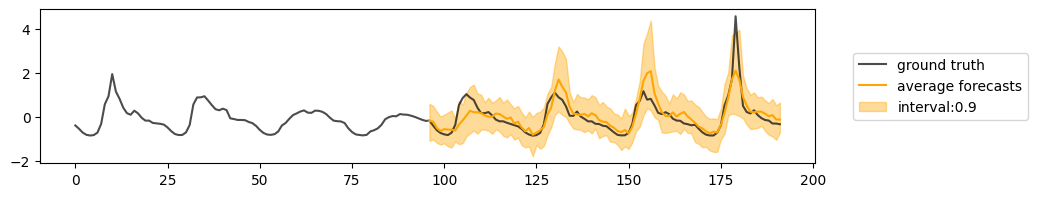

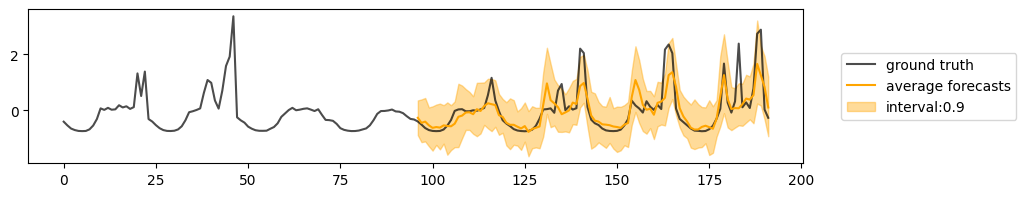

100


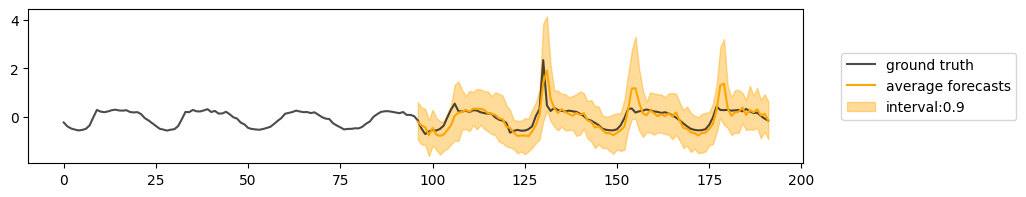

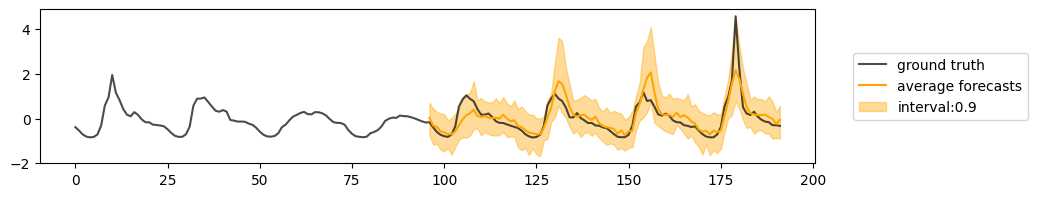

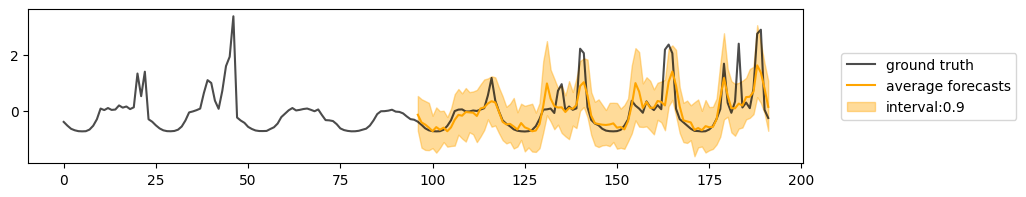

In [ ]:
model.forecaster.solver_schedule = 'linear'

for num_steps in steps:
    print(num_steps)
    model.forecaster.solver_num_steps = num_steps
    forecast_and_visualize(batch, model, num_chan=[0, 1, 9], num_samples=50, batch_idx=0, context_length=96, prediction_length=96)
    plt.show()

In [ ]:
ddim_linear_metrics = check_metrics_for_samplers(test_dataloader, model, trainer, steps=steps)

  0%|          | 0/6 [00:00<?, ?it/s]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2558686137199402     │
│     96_test_CRPS-Sum      │    0.16802284121513367    │
│       96_test_MASE        │    1.3174346685409546     │
│        96_test_MSE        │   0.001319656614214182    │
│      96_test_MSE-Sum      │    205.45957946777344     │
│        96_test_ND         │    0.3132276237010956     │
│      96_test_ND-Sum       │    0.2024092674255371     │
│       96_test_NRMSE       │    0.6163911819458008     │
│     96_test_NRMSE-Sum     │    0.27970364689826965    │
│    96_test_weighted_ND    │    0.3132276237010956     │
│  96_test_weighted_ND-Sum  │    0.2024092674255371     │
└───────────────────────────┴───────────────────────────┘

 17%|█▋        | 1/6 [07:10<35:50, 430.15s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2550460994243622     │
│     96_test_CRPS-Sum      │    0.1627330332994461     │
│       96_test_MASE        │    1.2892705202102661     │
│        96_test_MSE        │   0.001327999634668231    │
│      96_test_MSE-Sum      │     209.026123046875      │
│        96_test_ND         │    0.30714303255081177    │
│      96_test_ND-Sum       │    0.19637228548526764    │
│       96_test_NRMSE       │    0.6172998547554016     │
│     96_test_NRMSE-Sum     │    0.2802295982837677     │
│    96_test_weighted_ND    │    0.30714303255081177    │
│  96_test_weighted_ND-Sum  │    0.19637228548526764    │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 2/6 [14:25<28:53, 433.46s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2530204951763153     │
│     96_test_CRPS-Sum      │    0.15641193091869354    │
│       96_test_MASE        │    1.2721728086471558     │
│        96_test_MSE        │   0.0012996544828638434   │
│      96_test_MSE-Sum      │    198.94773864746094     │
│        96_test_ND         │    0.30302339792251587    │
│      96_test_ND-Sum       │    0.18990887701511383    │
│       96_test_NRMSE       │    0.6109318137168884     │
│     96_test_NRMSE-Sum     │    0.27327367663383484    │
│    96_test_weighted_ND    │    0.30302339792251587    │
│  96_test_weighted_ND-Sum  │    0.18990887701511383    │
└───────────────────────────┴───────────────────────────┘

 50%|█████     | 3/6 [21:44<21:47, 435.79s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2523787021636963     │
│     96_test_CRPS-Sum      │    0.15108682215213776    │
│       96_test_MASE        │    1.2595659494400024     │
│        96_test_MSE        │   0.0012865703320130706   │
│      96_test_MSE-Sum      │    194.82382202148438     │
│        96_test_ND         │     0.300235778093338     │
│      96_test_ND-Sum       │    0.1851561814546585     │
│       96_test_NRMSE       │    0.6084381937980652     │
│     96_test_NRMSE-Sum     │    0.2707539200782776     │
│    96_test_weighted_ND    │     0.300235778093338     │
│  96_test_weighted_ND-Sum  │    0.1851561814546585     │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 4/6 [29:08<14:38, 439.16s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25198471546173096    │
│     96_test_CRPS-Sum      │    0.1476580798625946     │
│       96_test_MASE        │    1.2527669668197632     │
│        96_test_MSE        │   0.0012785770231857896   │
│      96_test_MSE-Sum      │     192.2859344482422     │
│        96_test_ND         │    0.29833748936653137    │
│      96_test_ND-Sum       │    0.18213112652301788    │
│       96_test_NRMSE       │    0.6061044931411743     │
│     96_test_NRMSE-Sum     │    0.26808834075927734    │
│    96_test_weighted_ND    │    0.29833748936653137    │
│  96_test_weighted_ND-Sum  │    0.18213112652301788    │
└───────────────────────────┴───────────────────────────┘

 83%|████████▎ | 5/6 [36:47<07:26, 446.07s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25108951330184937    │
│     96_test_CRPS-Sum      │    0.14406365156173706    │
│       96_test_MASE        │    1.2438195943832397     │
│        96_test_MSE        │   0.001261663855984807    │
│      96_test_MSE-Sum      │     185.9127655029297     │
│        96_test_ND         │    0.29626184701919556    │
│      96_test_ND-Sum       │    0.1783106029033661     │
│       96_test_NRMSE       │    0.6023120880126953     │
│     96_test_NRMSE-Sum     │    0.2638084590435028     │
│    96_test_weighted_ND    │    0.29626184701919556    │
│  96_test_weighted_ND-Sum  │    0.1783106029033661     │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 6/6 [45:03<00:00, 450.60s/it]


In [ ]:
with open("ddim_linear_metrics_sssd.pkl", "wb") as fp:
   pickle.dump(ddim_linear_metrics, fp)

### DPM-Solver-1

In [ ]:
model.forecaster.solver = 'dpm1'
model.forecaster.solver_schedule = 'linear'

for batch in test_dataloader:
    break

In [ ]:
dpm_time = []
for num_steps in tqdm(steps):
    model.forecaster.solver_num_steps = num_steps
    dpm_time.append(time_for_forecast(batch, model, n_repeats=10))
dpm_time

100%|██████████| 6/6 [02:04<00:00, 20.69s/it]


[0.5544017076492309,
 0.7571916341781616,
 1.0834324836730957,
 1.6813057661056519,
 2.7605674028396607,
 5.5731069326400755]

In [ ]:
dpm1_metrics = check_metrics_for_samplers(test_dataloader, model, trainer, steps=steps)

  0%|          | 0/6 [00:00<?, ?it/s]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2560523450374603     │
│     96_test_CRPS-Sum      │    0.16828188300132751    │
│       96_test_MASE        │    1.3194376230239868     │
│        96_test_MSE        │   0.0013214549981057644   │
│      96_test_MSE-Sum      │    206.15223693847656     │
│        96_test_ND         │    0.3135843873023987     │
│      96_test_ND-Sum       │    0.20267237722873688    │
│       96_test_NRMSE       │     0.616627037525177     │
│     96_test_NRMSE-Sum     │    0.2799094617366791     │
│    96_test_weighted_ND    │    0.3135843873023987     │
│  96_test_weighted_ND-Sum  │    0.20267237722873688    │
└───────────────────────────┴───────────────────────────┘

 17%|█▋        | 1/6 [07:08<35:40, 428.20s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25514495372772217    │
│     96_test_CRPS-Sum      │    0.16277889907360077    │
│       96_test_MASE        │     1.290585994720459     │
│        96_test_MSE        │   0.0013274430530145764   │
│      96_test_MSE-Sum      │     208.8904266357422     │
│        96_test_ND         │    0.30749568343162537    │
│      96_test_ND-Sum       │    0.19679312407970428    │
│       96_test_NRMSE       │    0.6171639561653137     │
│     96_test_NRMSE-Sum     │    0.28006598353385925    │
│    96_test_weighted_ND    │    0.30749568343162537    │
│  96_test_weighted_ND-Sum  │    0.19679312407970428    │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 2/6 [14:22<28:46, 431.68s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2541923224925995     │
│     96_test_CRPS-Sum      │    0.15817613899707794    │
│       96_test_MASE        │     1.277953863143921     │
│        96_test_MSE        │   0.0013109762221574783   │
│      96_test_MSE-Sum      │      203.3896484375       │
│        96_test_ND         │    0.3044823706150055     │
│      96_test_ND-Sum       │    0.19201502203941345    │
│       96_test_NRMSE       │    0.6135552525520325     │
│     96_test_NRMSE-Sum     │    0.2764553427696228     │
│    96_test_weighted_ND    │    0.3044823706150055     │
│  96_test_weighted_ND-Sum  │    0.19201502203941345    │
└───────────────────────────┴───────────────────────────┘

 50%|█████     | 3/6 [21:39<21:42, 434.03s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25212907791137695    │
│     96_test_CRPS-Sum      │    0.15076133608818054    │
│       96_test_MASE        │    1.2587460279464722     │
│        96_test_MSE        │   0.001286121318116784    │
│      96_test_MSE-Sum      │    194.56951904296875     │
│        96_test_ND         │    0.29989296197891235    │
│      96_test_ND-Sum       │    0.1850735992193222     │
│       96_test_NRMSE       │    0.6080333590507507     │
│     96_test_NRMSE-Sum     │    0.2702023983001709     │
│    96_test_weighted_ND    │    0.29989296197891235    │
│  96_test_weighted_ND-Sum  │    0.1850735992193222     │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 4/6 [28:59<14:32, 436.36s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25157493352890015    │
│     96_test_CRPS-Sum      │    0.14715228974819183    │
│       96_test_MASE        │    1.2507944107055664     │
│        96_test_MSE        │   0.001271721557714045    │
│      96_test_MSE-Sum      │    189.45274353027344     │
│        96_test_ND         │    0.2979513704776764     │
│      96_test_ND-Sum       │    0.18164412677288055    │
│       96_test_NRMSE       │    0.6046439409255981     │
│     96_test_NRMSE-Sum     │    0.2664232850074768     │
│    96_test_weighted_ND    │    0.2979513704776764     │
│  96_test_weighted_ND-Sum  │    0.18164412677288055    │
└───────────────────────────┴───────────────────────────┘

 83%|████████▎ | 5/6 [36:36<07:23, 443.90s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2512778341770172     │
│     96_test_CRPS-Sum      │    0.14457981288433075    │
│       96_test_MASE        │    1.2446876764297485     │
│        96_test_MSE        │   0.0012627196265384555   │
│      96_test_MSE-Sum      │    186.44024658203125     │
│        96_test_ND         │    0.2965056300163269     │
│      96_test_ND-Sum       │    0.17907483875751495    │
│       96_test_NRMSE       │    0.6028640866279602     │
│     96_test_NRMSE-Sum     │    0.2643812894821167     │
│    96_test_weighted_ND    │    0.2965056300163269     │
│  96_test_weighted_ND-Sum  │    0.17907483875751495    │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 6/6 [44:47<00:00, 447.84s/it]


In [ ]:
with open("dpm1_metrics_sssd.pkl", "wb") as fp:
   pickle.dump(dpm1_metrics, fp)

10


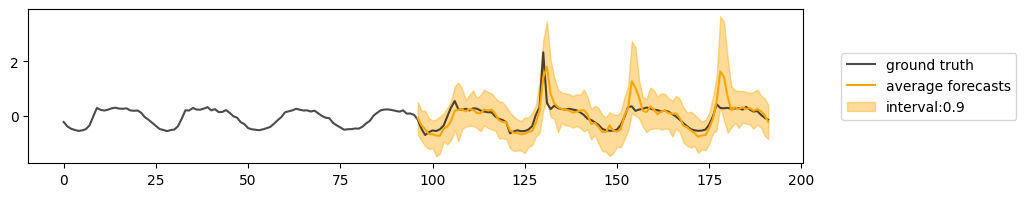

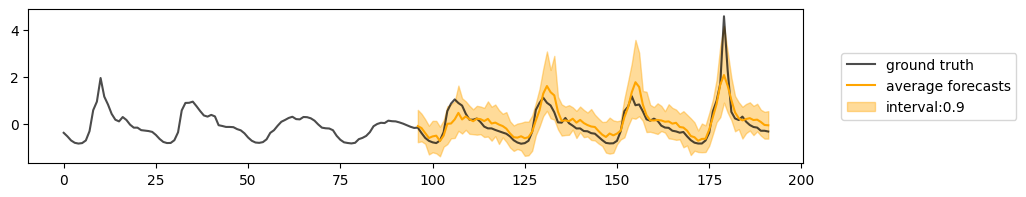

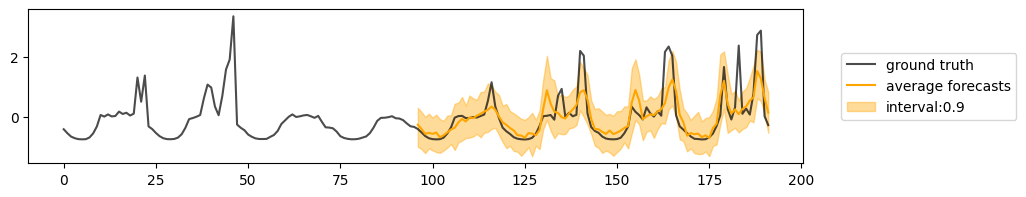

15


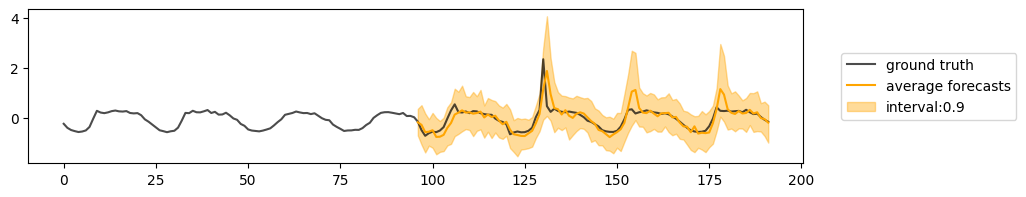

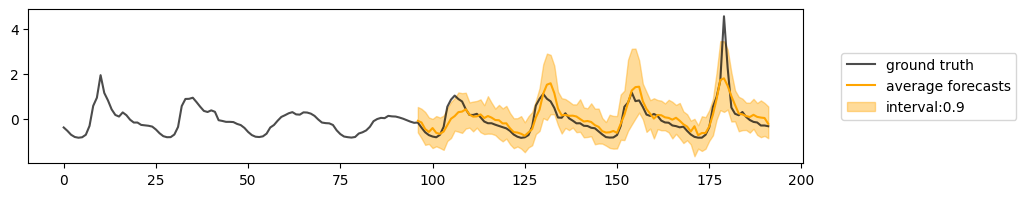

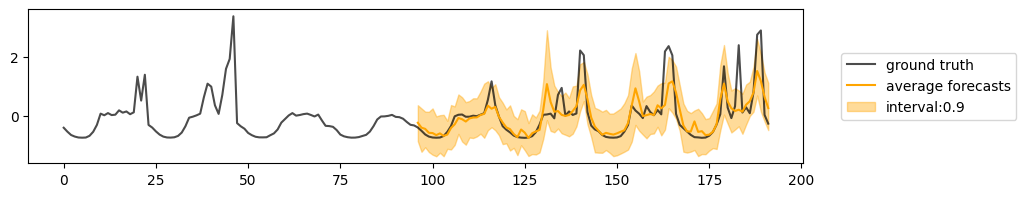

20


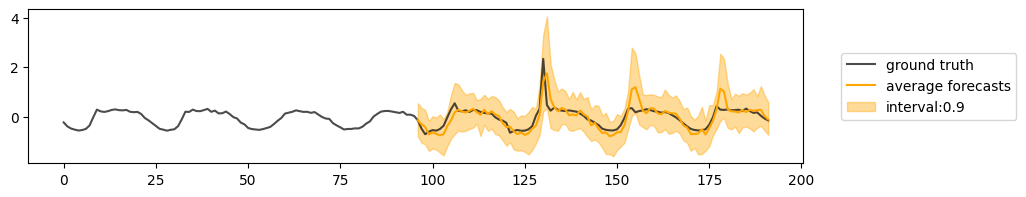

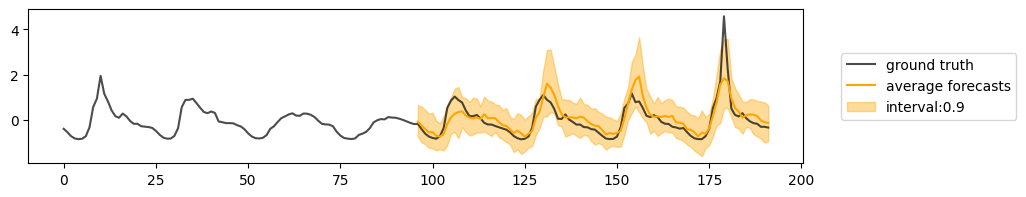

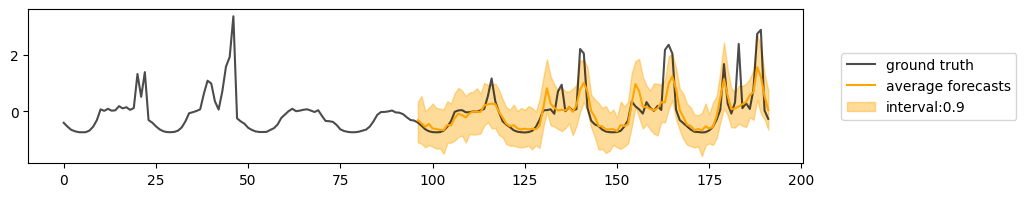

30


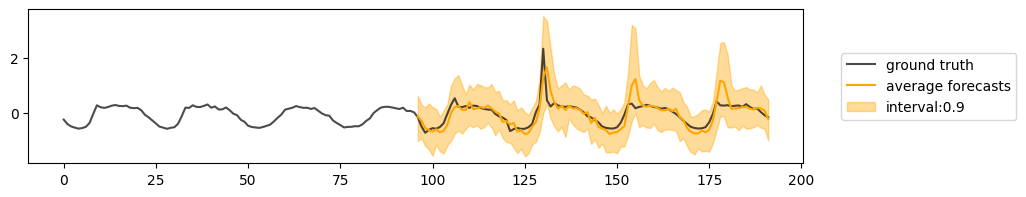

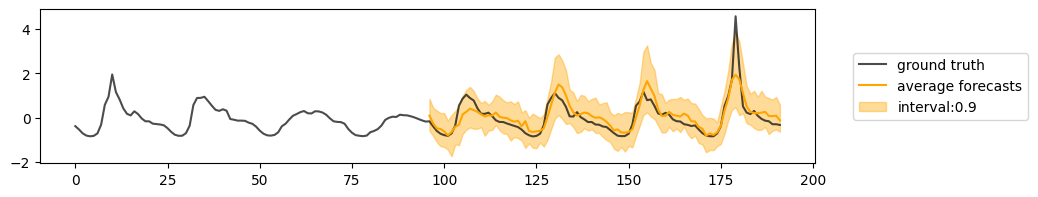

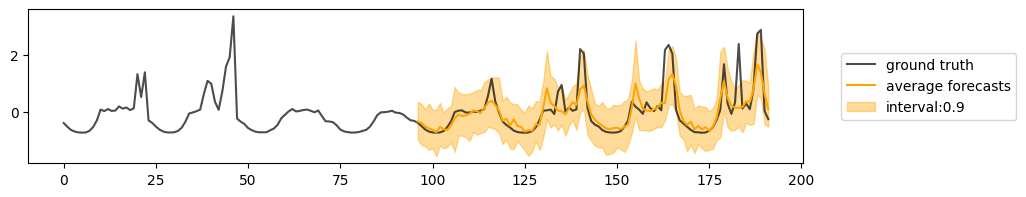

50


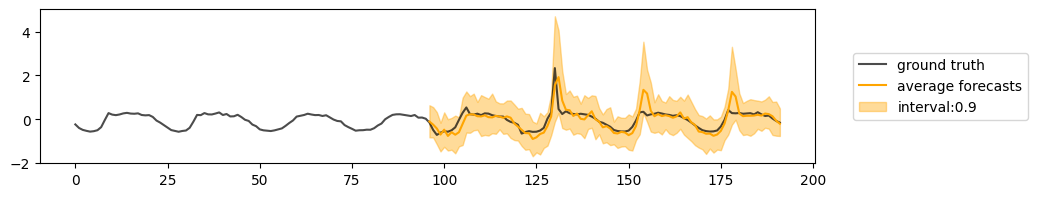

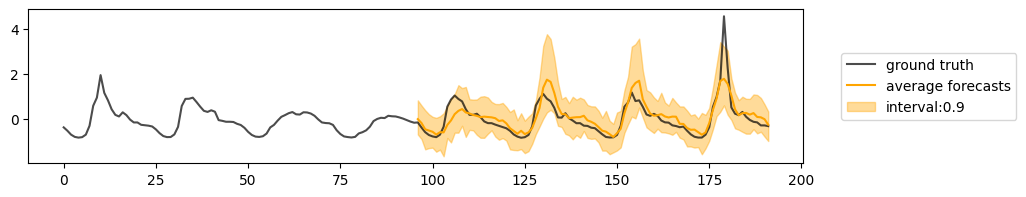

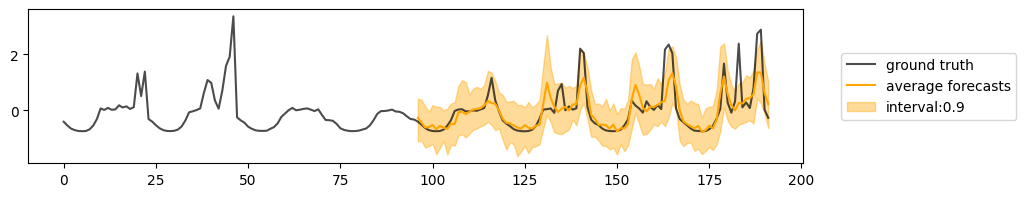

100


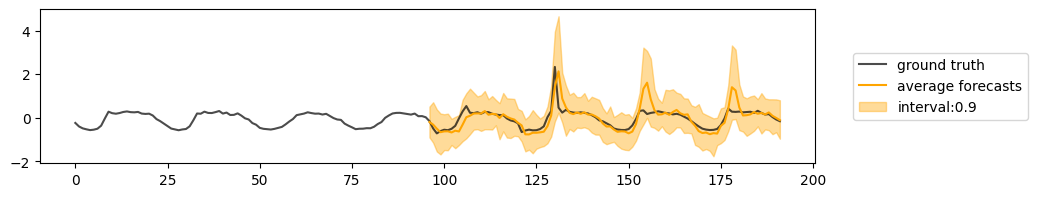

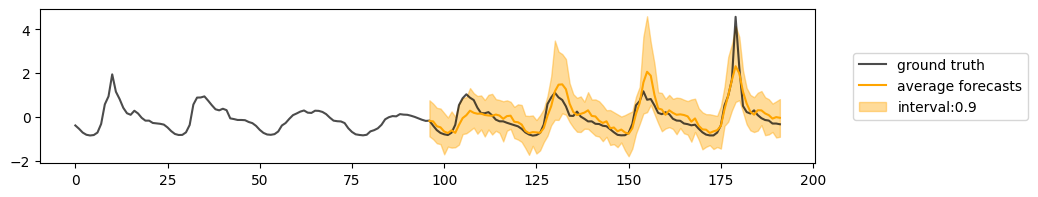

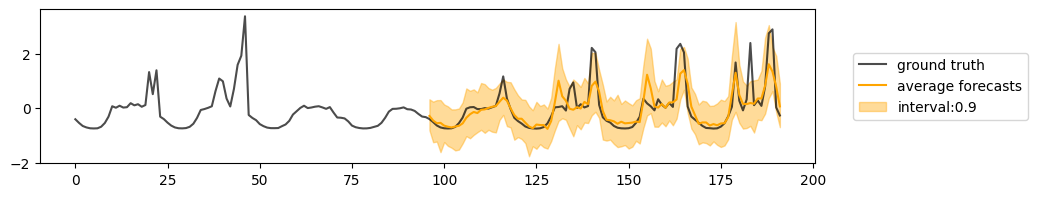

In [ ]:
for num_steps in steps:
    print(num_steps)
    model.forecaster.solver_num_steps = num_steps
    forecast_and_visualize(batch, model, num_chan=[0, 1, 9], num_samples=50, batch_idx=0, context_length=96, prediction_length=96)
    plt.show()

### DPM-Solver-2

In [ ]:
model.forecaster.solver = 'dpm2'
model.forecaster.solver_schedule = 'linear'
model.scaler = data_manager.scaler
model.forecaster.solver_num_steps = 15

steps = [10, 15, 20, 30, 50, 100]
for batch in test_dataloader:
    break

In [ ]:
dpm_time = []
for num_steps in tqdm(steps):
    model.forecaster.solver_num_steps = num_steps // 2
    dpm_time.append(time_for_forecast(batch, model, n_repeats=10))
dpm_time

100%|██████████| 6/6 [01:57<00:00, 19.63s/it]


[0.4273616075515747,
 0.6898735046386719,
 1.0074413537979126,
 1.5351543188095094,
 2.6474083185195925,
 5.469812107086182]

In [ ]:
dpm2_metrics = check_metrics_for_samplers(test_dataloader, model, trainer, steps=[step // 2 for step in steps])

  0%|          | 0/6 [00:00<?, ?it/s]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    1.2903391122817993     │
│     96_test_CRPS-Sum      │    1.0703059434890747     │
│       96_test_MASE        │     6.742096424102783     │
│        96_test_MSE        │    0.03279763087630272    │
│      96_test_MSE-Sum      │       12851.6484375       │
│        96_test_ND         │    1.6203588247299194     │
│      96_test_ND-Sum       │     1.405937910079956     │
│       96_test_NRMSE       │    3.1175613403320312     │
│     96_test_NRMSE-Sum     │    2.2602384090423584     │
│    96_test_weighted_ND    │    1.6203588247299194     │
│  96_test_weighted_ND-Sum  │     1.405937910079956     │
└───────────────────────────┴───────────────────────────┘

 17%|█▋        | 1/6 [07:23<36:57, 443.42s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2719770669937134     │
│     96_test_CRPS-Sum      │    0.18489620089530945    │
│       96_test_MASE        │     1.44459068775177      │
│        96_test_MSE        │    0.00136398000176996    │
│      96_test_MSE-Sum      │     222.2206268310547     │
│        96_test_ND         │    0.34099987149238586    │
│      96_test_ND-Sum       │    0.2230559140443802     │
│       96_test_NRMSE       │     0.629330039024353     │
│     96_test_NRMSE-Sum     │    0.29477307200431824    │
│    96_test_weighted_ND    │    0.34099987149238586    │
│  96_test_weighted_ND-Sum  │    0.2230559140443802     │
└───────────────────────────┴───────────────────────────┘

 33%|███▎      | 2/6 [14:49<29:39, 444.98s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25626659393310547    │
│     96_test_CRPS-Sum      │    0.16848400235176086    │
│       96_test_MASE        │     1.319549322128296     │
│        96_test_MSE        │   0.0013237192761152983   │
│      96_test_MSE-Sum      │     206.804931640625      │
│        96_test_ND         │    0.31365758180618286    │
│      96_test_ND-Sum       │    0.20292063057422638    │
│       96_test_NRMSE       │    0.6172228455543518     │
│     96_test_NRMSE-Sum     │    0.28043410181999207    │
│    96_test_weighted_ND    │    0.31365758180618286    │
│  96_test_weighted_ND-Sum  │    0.20292063057422638    │
└───────────────────────────┴───────────────────────────┘

 50%|█████     | 3/6 [22:20<22:23, 447.96s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2544678747653961     │
│     96_test_CRPS-Sum      │    0.16176852583885193    │
│       96_test_MASE        │    1.2865420579910278     │
│        96_test_MSE        │   0.001320284092798829    │
│      96_test_MSE-Sum      │    206.18157958984375     │
│        96_test_ND         │     0.306405633687973     │
│      96_test_ND-Sum       │    0.19517745077610016    │
│       96_test_NRMSE       │    0.6154902577400208     │
│     96_test_NRMSE-Sum     │     0.27816241979599      │
│    96_test_weighted_ND    │     0.306405633687973     │
│  96_test_weighted_ND-Sum  │    0.19517745077610016    │
└───────────────────────────┴───────────────────────────┘

 67%|██████▋   | 4/6 [29:54<15:00, 450.31s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.25194287300109863    │
│     96_test_CRPS-Sum      │    0.15179523825645447    │
│       96_test_MASE        │    1.2602777481079102     │
│        96_test_MSE        │    0.00128762552049011    │
│      96_test_MSE-Sum      │    194.77816772460938     │
│        96_test_ND         │    0.3002100884914398     │
│      96_test_ND-Sum       │    0.18584555387496948    │
│       96_test_NRMSE       │    0.6082940697669983     │
│     96_test_NRMSE-Sum     │    0.2702914774417877     │
│    96_test_weighted_ND    │    0.3002100884914398     │
│  96_test_weighted_ND-Sum  │    0.18584555387496948    │
└───────────────────────────┴───────────────────────────┘

 83%|████████▎ | 5/6 [37:43<07:36, 456.80s/it]INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.2517955005168915     │
│     96_test_CRPS-Sum      │    0.14756396412849426    │
│       96_test_MASE        │    1.2518970966339111     │
│        96_test_MSE        │   0.0012757080839946866   │
│      96_test_MSE-Sum      │    190.85342407226562     │
│        96_test_ND         │    0.29819339513778687    │
│      96_test_ND-Sum       │    0.18218468129634857    │
│       96_test_NRMSE       │    0.6055043339729309     │
│     96_test_NRMSE-Sum     │    0.26716160774230957    │
│    96_test_weighted_ND    │    0.29819339513778687    │
│  96_test_weighted_ND-Sum  │    0.18218468129634857    │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 6/6 [45:47<00:00, 457.94s/it]


In [ ]:
import pickle
with open("dpm2_metrics_sssd.pkl", "wb") as fp:
   pickle.dump(dpm2_metrics, fp)

10


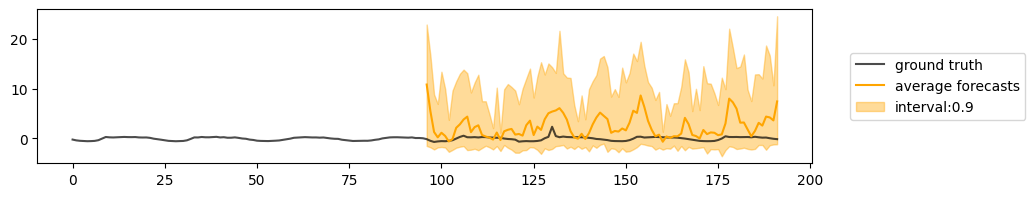

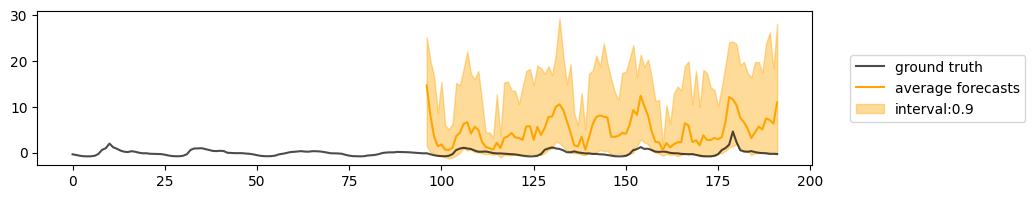

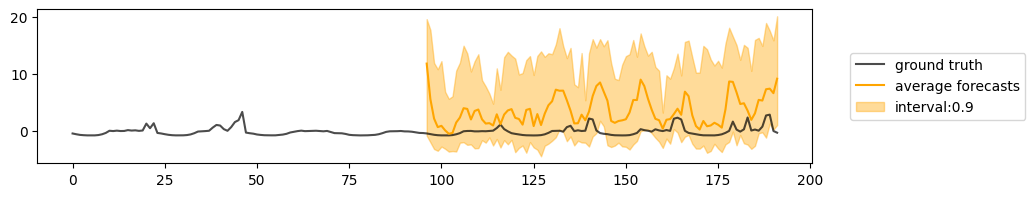

15


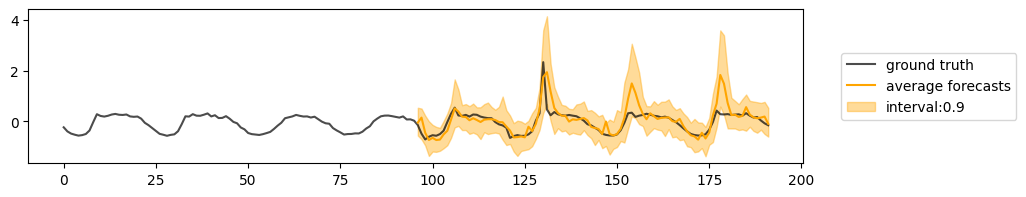

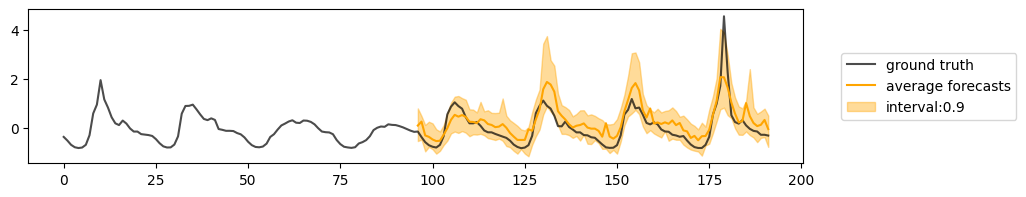

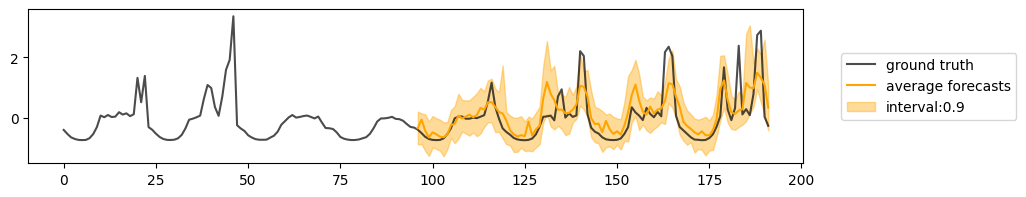

20


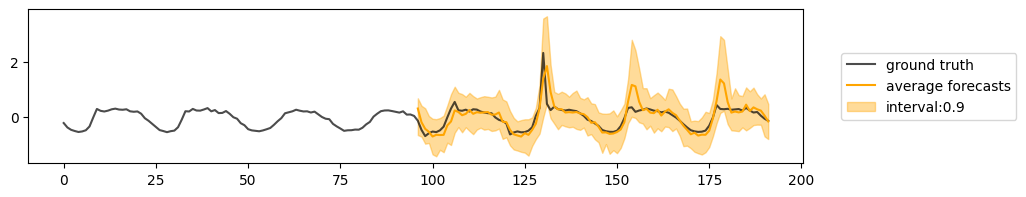

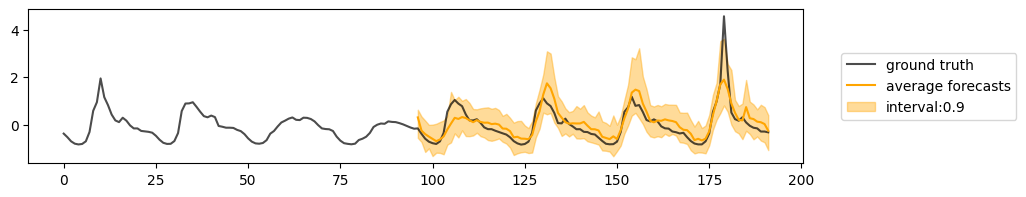

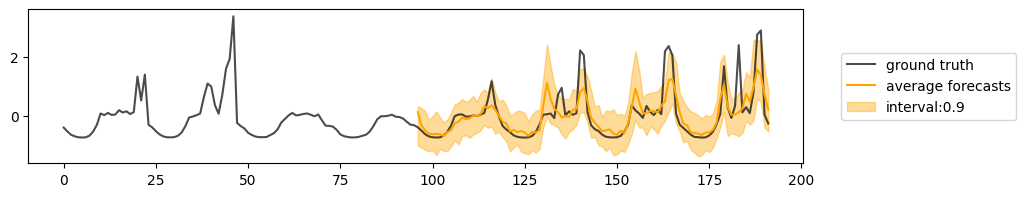

30


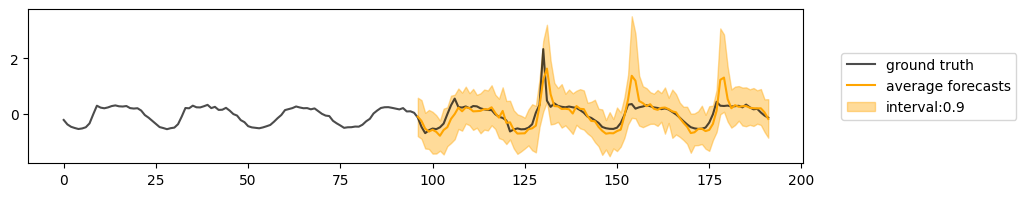

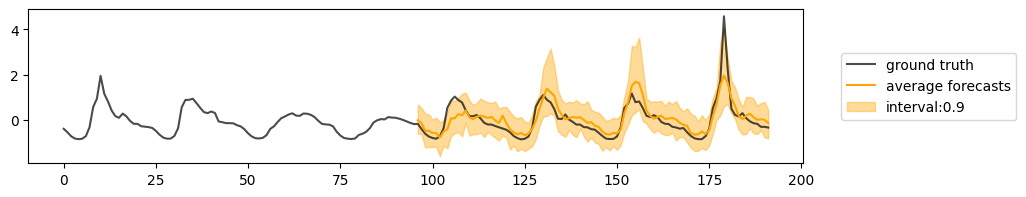

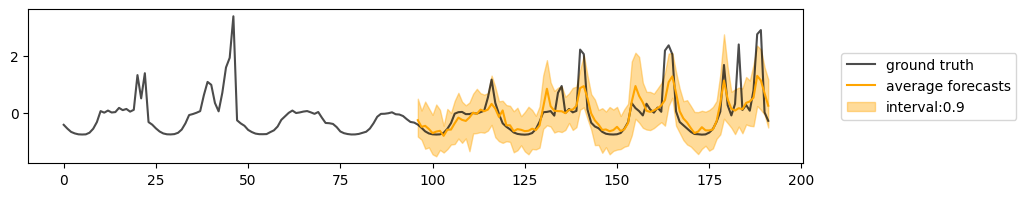

50


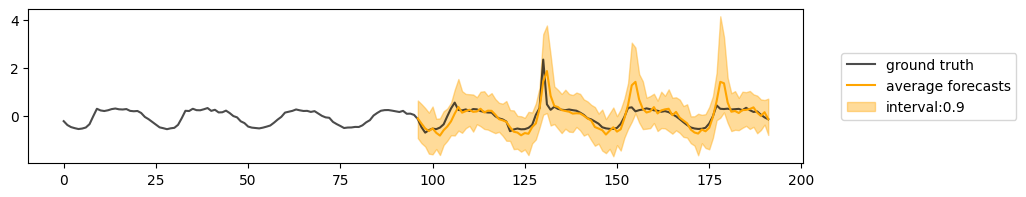

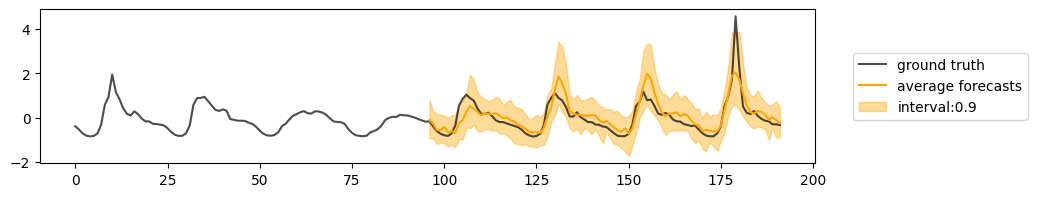

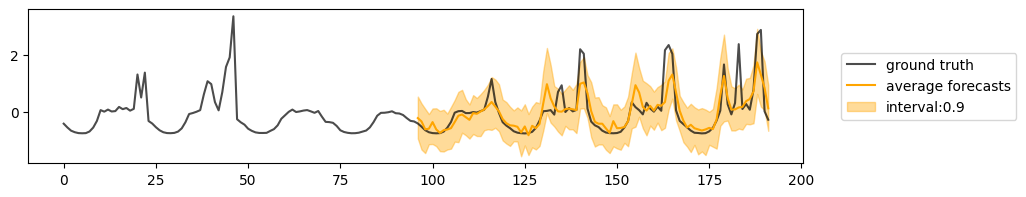

100


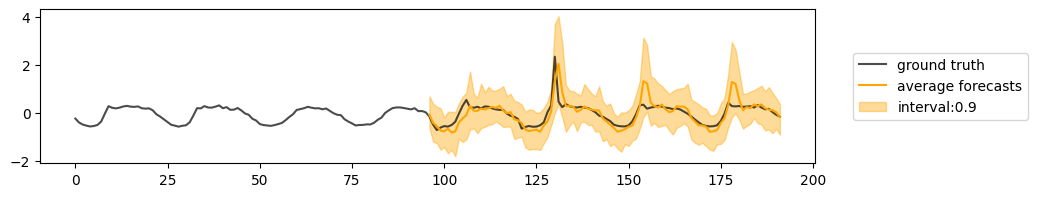

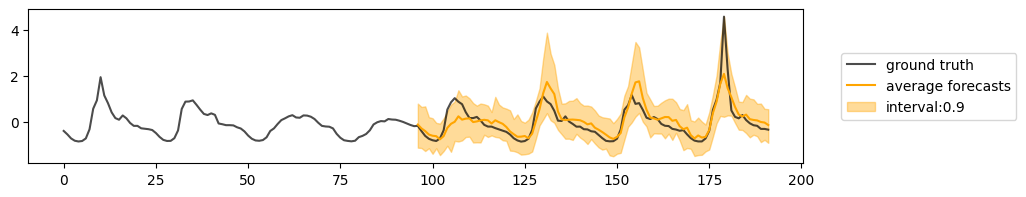

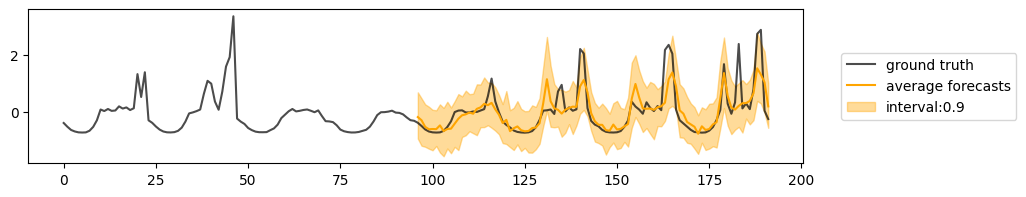

In [ ]:
for num_steps in steps:
    print(num_steps)
    model.forecaster.solver_num_steps = num_steps // 2
    forecast_and_visualize(batch, model, num_chan=[0, 1, 9], num_samples=50, batch_idx=0, context_length=96, prediction_length=96)
    plt.show()

### Plot results

In [3]:
import pickle
import os

metrics = {}
samplers_name = ['DDIM, linear', 'DDIM, quad', 'DPM-Solver-1', 'DPM-Solver-2', 'Euler', 'Heun']
for i, file in enumerate(sorted(os.listdir("samplers_res/"))):
    with open(f"samplers_res/{file}", "rb") as fp:
        metrics[samplers_name[i]] = pickle.load(fp)

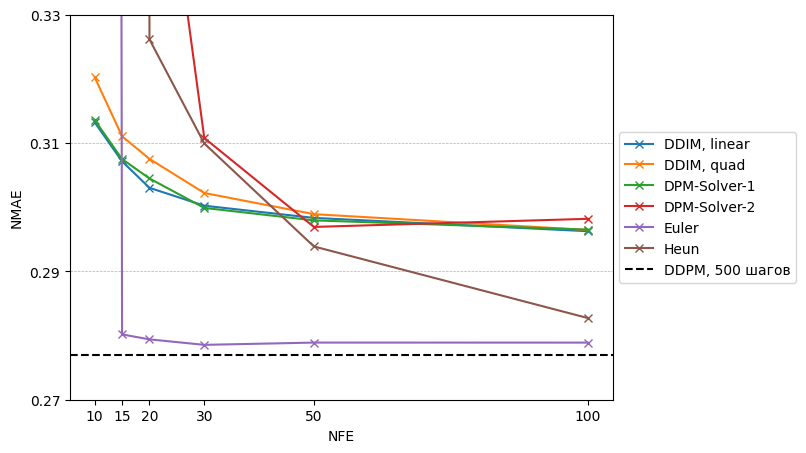

In [23]:
import matplotlib.pyplot as plt
import numpy as np

nfe = [10, 15, 20, 30, 50, 100]
plt.figure(figsize=(7, 5))

for sampler in metrics:
    runs = metrics[sampler]
    nmae = [run['96_test_ND'] for run in runs]
    plt.plot(nfe, nmae, marker='x', linestyle='-', label=sampler)

plt.axhline(y=0.27691203355789185, linestyle='--', label='DDPM, 500 шагов', c='black')

plt.xlabel('NFE')
plt.xticks(nfe)
plt.ylabel('NMAE')
plt.yticks(np.arange(0.27, 0.351, 0.02))
plt.ylim(0.27, 0.33)
plt.grid(True, which="both", ls="--", linewidth=0.5, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

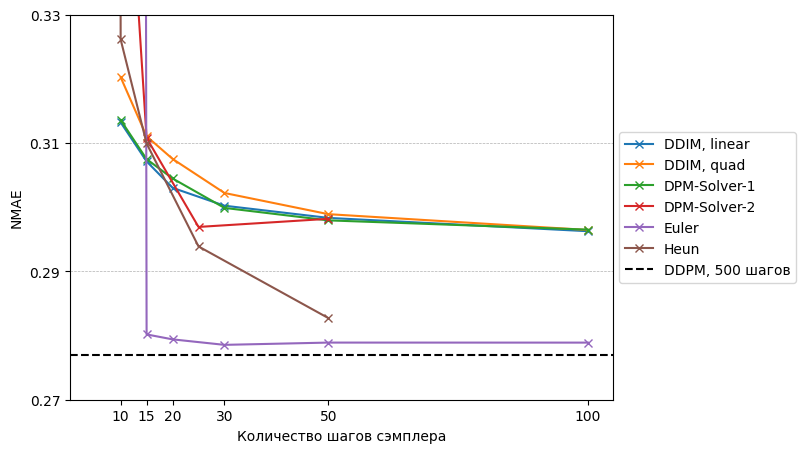

In [22]:
solver_steps = [10, 15, 20, 30, 50, 100]
solver_steps_2ord = [step // 2 for step in solver_steps]
plt.figure(figsize=(7, 5))

for sampler in metrics:
    runs = metrics[sampler]
    nmae = [run['96_test_ND'] for run in runs]
    if sampler in ['Heun', 'DPM-Solver-2']:
        plt.plot(solver_steps_2ord, nmae, marker='x', linestyle='-', label=sampler)
    else:
        plt.plot(solver_steps, nmae, marker='x', linestyle='-', label=sampler)

plt.axhline(y=0.27691203355789185, linestyle='--', label='DDPM, 500 шагов', c='black')

plt.xlabel('Количество шагов сэмплера')
plt.xticks(solver_steps)
plt.ylabel('NMAE')
plt.yticks(np.arange(0.27, 0.351, 0.02))
plt.ylim(0.27, 0.33)
plt.grid(True, which="both", ls="--", linewidth=0.5, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

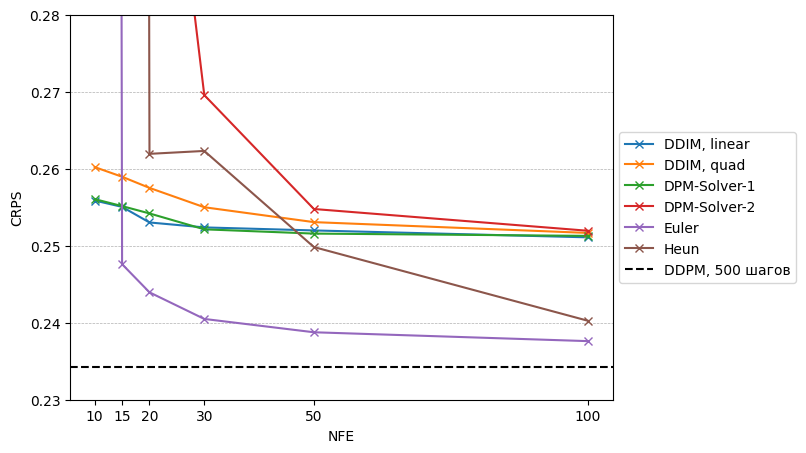

In [18]:
nfe = [10, 15, 20, 30, 50, 100]
plt.figure(figsize=(7, 5))

for sampler in metrics:
    runs = metrics[sampler]
    crps = [run['96_test_CRPS'] for run in runs]
    plt.plot(nfe, crps, marker='x', linestyle='-', label=sampler)

plt.axhline(y=0.23427969217300415, linestyle='--', label='DDPM, 500 шагов', c='black')

plt.xlabel('NFE')
plt.xticks(nfe)
plt.ylabel('CRPS')
plt.ylim(0.23, 0.28)
plt.grid(True, which="both", ls="--", linewidth=0.5, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

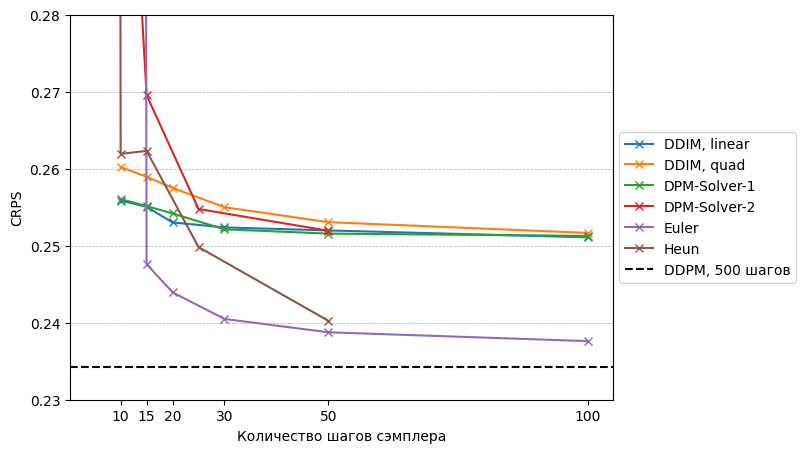

In [26]:
plt.figure(figsize=(7, 5))

for sampler in metrics:
    runs = metrics[sampler]
    crps = [run['96_test_CRPS'] for run in runs]
    if sampler in ['Heun', 'DPM-Solver-2']:
        plt.plot(solver_steps_2ord, crps, marker='x', linestyle='-', label=sampler)
    else:
        plt.plot(solver_steps, crps, marker='x', linestyle='-', label=sampler)

plt.axhline(y=0.23427969217300415, linestyle='--', label='DDPM, 500 шагов', c='black')

plt.xlabel('Количество шагов сэмплера')
plt.xticks(solver_steps)
plt.ylabel('CRPS')
plt.ylim(0.23, 0.28)
plt.grid(True, which="both", ls="--", linewidth=0.5, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));